

```
   _____                                      _____ 
  / ____|                               /\   |_   _|
 | |  __  __ _ _ __ ___   ___          /  \    | |  
 | | |_ |/ _` | '_ ` _ \ / _ \        / /\ \   | |  
 | |__| | (_| | | | | | |  __/       / ____ \ _| |_ 
  \_____|\__,_|_| |_| |_|\___|      /_/    \_\_____|

```


                                               
                                               

                                               
                                               

                                               


Hello and welcome to the Devs AI workshop!

In this workshop, you will ***evolve*** your ***own*** AI gaming companion! It will learn to play pong against you, and even learn to walk!

First things first - Lets install some dependencies! You'll need to decide how you want to follow along:

  1) You can continue in this notebook without installing anything on your local computer, however unfortunately this method can be slightly slow and is not able to run the interactive games.

  2) For the full experience, you may want to follow along on your local system. You can find setup instructions on the github repository.

# Install Dependencies

May take a minute or two to set everything up

In [45]:
#@title Install Dependencies with Pip { display-mode: "form" }
#Piping to " > /dev/null 2>&1" to remove unneeded output cluttering notebook
!git clone https://github.com/BenHals/GeneticPong.git
%cd GeneticPong
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[all] > /dev/null 2>&1
# Can Ignore the error here, don't need to restart
!pip install box2d-py > /dev/null 2>&1


fatal: destination path 'GeneticPong' already exists and is not an empty directory.
/content/GeneticPong/GeneticPong


In [46]:
#@title Imports and create Virtual Display { display-mode: "form" }
import gym
from gym import logger as gymlogger
from gym import spaces
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import copy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import json
import pyglet
pyglet.options["debug_gl"] = False


from IPython.display import HTML

from IPython import display as ipythondisplay

# Start virtual display - Needed for notebook, since it is run in the cloud without a real display.
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def multi_agent_step(self, action):
    self._before_step(action)
    observation, (reward_l, reward_r), done, info = self.env.step(action)
    done = self._after_step(observation, reward_r, done, info)

    return observation, (reward_l, reward_r), done, info
def single_agent_step(self, action):
    self._before_step(action)
    observation, reward, done, info = self.env.step(action)
    done = self._after_step(observation, reward, done, info)

    return observation, reward, done, info

from customPong import CustomPong
from gym.envs.classic_control import rendering

In [47]:
#@title Utility functions for display { display-mode: "form" }

def show_video():
  """ Show recorded videos in the notebook
  """
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    for mp4 in sorted(mp4list, key = lambda fn: float(fn.split('video')[3].split('.mp4')[0])):
      video = io.open(mp4, 'r+b').read()
      encoded = base64.b64encode(video)
      ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def record_env(env):
  """ Create a recorded environment.
  Videos are saved to the ./video folder
  """
  Monitor.step = multi_agent_step
  env = Monitor(env, './video', force=True, video_callable=lambda episode_id: True)
  return env
def record_env_walker(env):
  """ Create a recorded environment.
  Videos are saved to the ./video folder
  """
  Monitor.step = single_agent_step
  env = Monitor(env, './video', force=True, video_callable=lambda episode_id: True)
  return env


# Test Setup & Demo

Lets start with a little demo to test everything is correctly setup!

We are going to play two pretrained AI agents against eachother, and watch the results!

## Setup player
First, we will create an artificial 'brain' and load some neurons which have been pretrained. We'll discuss what exactly these are later in the workshop!

Something to note here - The neurons are 'just' numbers! This is all we need to store to represent our AIs!

We have pretrained and saved some AIs with different skill levels for you to try out!

In [48]:
# Import the workshop code answers from the github - You will be writing these files yourself later in the workshop!
from customPong import CustomPong
from neural_network import SlowNeuralNet, FastNeuralNet

# Set a setting for display
CustomPong.metadata["video.frames_per_second"] = 200

np.random.seed(43)

# Create our 'Artificial Player'!
# Its 'brain' is empty right now, we need to set its neurons
pong_player = SlowNeuralNet([1], 0)

# A terrible set of neurons, evolved over one generation
pretrained_neurons_terrible = {"fitness": -0.26521108186056086, "nodeCount": [5, 13, 8, 13, 3], "neurons": [["{\"bias\": -0.5882788970088781, \"weights\": [0.27258819101594445, -0.55582427861649, -0.49102199212710196, 0.3813068061728839, 0.3896434367203516]}", "{\"bias\": 0.7122329220655936, \"weights\": [-0.8611671908299547, 0.15161772582010347, 0.9252785542065403, 0.9362518104321891, 0.3460124673770648]}", "{\"bias\": 0.8310272785980479, \"weights\": [0.31847957496530066, 0.3668577585493291, -0.46268911738733975, -0.2654260023067023, 0.5420025197472218]}", "{\"bias\": 0.5358917201491966, \"weights\": [-0.486370486734349, 0.7260667417467914, -0.8467812685534073, -0.12859620930466864, -0.5169514879397397]}", "{\"bias\": -0.1816656459053494, \"weights\": [-0.50850173334246, 0.03385921380884516, 0.3441546900378132, -0.7682707226846595, -0.911601334983069]}", "{\"bias\": -0.7951149876317525, \"weights\": [-0.8922518147475014, 0.19264564747551827, -0.23243456287556907, 0.007139299973125457, 0.5123321973152519]}", "{\"bias\": 0.7372795828961474, \"weights\": [0.14226977310345856, -0.565561703255874, 0.7748217969996769, 0.607064183896765, -0.32809848019131116]}", "{\"bias\": 0.5329582544951215, \"weights\": [0.9917209784174612, 0.9893921130890146, 0.4321405098355129, 0.9782935827267984, -0.43642187608024696]}", "{\"bias\": 0.5241861603237876, \"weights\": [0.8798811402710229, 0.8063248703463104, -0.017937546538079108, -0.9095577198576847, -0.543284151890143]}", "{\"bias\": 0.2763145689074107, \"weights\": [0.19174384608942852, -0.8887475987587354, 0.6746941624106377, -0.31356812063420536, 0.15961777654760056]}", "{\"bias\": 0.8291745772515631, \"weights\": [0.6205606723897574, 0.953483309349153, 0.708961302254068, -0.9116294116564159, -0.664151491323486]}", "{\"bias\": -0.8939907111061223, \"weights\": [-0.4294439446410363, -0.9127228202950461, -0.23763757781575667, -0.874524021931139, -0.4814030953238868]}", "{\"bias\": 0.08169518146763632, \"weights\": [-0.700430041659104, -0.5891515336091562, 0.5246763249660942, -0.7245466810419401, 0.41009938038714755]}"], ["{\"bias\": 0.2143459000361423, \"weights\": [-0.7022861202639092, 0.13363888477008512, 0.3513280199611315, 0.812611090436997, -0.30374736888080633, 0.19590751754890623, 0.8442378031461102, -0.9189155635127251, -0.9626357627458266, 0.12376115903179219, 0.8547249221038107, -0.8718125531681882, -0.02944704779970686]}", "{\"bias\": 0.4003013542154048, \"weights\": [-0.2353545560698147, -0.6676871666267123, 0.9412032108572745, 0.8035378042067087, 0.6996014836787867, -0.6739064080570427, -0.8717847339334361, -0.459126918776537, 0.5760077784126187, 0.2414146481588848, -0.8165673559364823, -0.2771848968322408, -0.009786123243050282]}", "{\"bias\": 0.5903876441354421, \"weights\": [0.7650515610063495, 0.42999762002724573, -0.4415610281357296, -0.902293458785683, 0.771861065349098, 0.6619400260314245, 0.7303626627459945, 0.5770428678245154, 0.2943763818684908, -0.4928350308282943, -0.6318514096548995, 0.5504898426499636, 0.5327704681163021]}", "{\"bias\": -0.43844503891682884, \"weights\": [0.10850490400026214, 0.8008333018909299, -0.7647024931187263, 0.5810923012260807, -0.7006902055636073, -0.9149754006706914, -0.5326490332351081, 0.32287391365323637, 0.7638494949496191, -0.31169760716821626, 0.23811281837455933, 0.043636214598403944, -0.895001295585748]}", "{\"bias\": 0.8362868619399262, \"weights\": [-0.2522039135065146, 0.7527737010951596, 0.4238770124839, -0.3556635192255091, -0.5537113022892834, 0.018831507299707617, 0.740698645234491, -0.9828408499649652, -0.9442274379257338, -0.2677380865110186, 0.9503566320560228, -0.7431102259867948, 0.48089703406534157]}", "{\"bias\": -0.3970072791168353, \"weights\": [-0.01234359363942783, 0.8574341167838657, 0.3210544213583608, -0.44548113121694755, -0.17544893827332864, -0.381846417230153, 0.38362185061305554, -0.6962910458401004, 0.5019156060734389, 0.25375418163370256, -0.9824890972585361, -0.42614144158814393, -0.885376541193527]}", "{\"bias\": -0.21804061173184297, \"weights\": [0.08479524763194446, 0.24724576888329497, -0.9638051260499725, 0.2697392198000226, 0.6903858236238523, 0.26973154145380107, 0.2571965616398235, 0.38086730322723916, 0.7954262122511941, 0.7261114336700594, -0.7374177502969843, -0.1655443805468293, 0.5254154915212645]}", "{\"bias\": -0.7989112059219265, \"weights\": [0.20377813215494944, -0.31218700774280106, 0.9213646193381677, -0.3838635767140459, 0.4996214971464503, -0.6849572639509904, 0.5939597908006045, 0.6575973448895229, 0.3402455779890763, -0.2325890262165553, -0.5166792678994931, -0.42472535336334105, 0.4481992012596523]}"], ["{\"bias\": -0.7088486644917722, \"weights\": [0.4766833814575986, -0.4755451741090151, 0.6809548847494891, 0.22688975436006498, -0.8800426001412447, -0.12762917785577832, -0.2616611000607605, -0.23678485874212285]}", "{\"bias\": -0.23436249269044285, \"weights\": [0.9091178830349069, 0.337157079105882, 0.8539713509138782, -0.3877188260969864, 0.8198165874238834, 0.45390956830276563, -0.982613376778654, -0.9404416553797383]}", "{\"bias\": -0.28120625820644807, \"weights\": [0.1530496647184485, 0.03775901024116313, 0.3408907694911081, 0.4593809638631945, -0.4769837548671225, -0.08138615982897468, 0.10198419328525055, 0.9602537360279593]}", "{\"bias\": -0.015588523445225766, \"weights\": [-0.013693773228176553, 0.49645897460341515, 0.5137461291133116, -0.5867995056240514, -0.34406080671600137, 0.8034841673881525, 0.6968458757081943, 0.9346737409351249]}", "{\"bias\": 0.5280357617371563, \"weights\": [0.6317021468969901, 0.201578858290842, 0.39822361549157126, 0.8552207719979408, 0.3668396668490246, -0.2740287269239239, 0.055236936707340645, 0.23495333869474244]}", "{\"bias\": 0.73271362327587, \"weights\": [0.0047543815288002556, 0.6500656438892203, -0.22744687524337648, -0.7645186442752059, 0.006867291261202002, -0.8862692685109026, 0.8872011580690131, -0.8736743972639711]}", "{\"bias\": -0.10105521108003801, \"weights\": [-0.16283318323842866, 0.7792101147608113, -0.5566804908419518, -0.796716967289796, 0.07283925754687415, 0.8500407150527736, -0.2010548556153675, -0.5876050472111021]}", "{\"bias\": -0.6314085787662707, \"weights\": [0.6557325490283938, -0.24734043217361878, 0.9410188790402154, -0.22093329365851333, 0.5040824601961544, 0.3557644999570426, -0.9725912587844132, 0.9687070070702011]}", "{\"bias\": 0.09788023643987898, \"weights\": [-0.955762217225262, -0.5052767749617202, 0.8200253141727214, 0.5777751692346775, 0.4051587752631258, -0.9481086133526626, 0.8070328454783333, 0.6472636039662671]}", "{\"bias\": 0.03465124351301019, \"weights\": [0.7350046836817064, -0.6085351125967338, -0.8241767597654661, 0.8368025510936148, 0.6633650847449755, 0.23188044690416798, 0.2548543735788449, -0.1947282217217925]}", "{\"bias\": -0.7955752888582086, \"weights\": [-0.6865454904374331, 0.968851129228367, -0.4516121143499219, 0.15124800954571938, -0.17411705818972867, 0.132877745903476, 0.1548075492592147, -0.33160995951855576]}", "{\"bias\": -0.41851482210076685, \"weights\": [0.07660388471331658, -0.4987229296100659, 0.8644838904750323, 0.7478114324813756, 0.14838941988509435, 0.14769998950379715, -0.7568545413868595, -0.06859287346339249]}", "{\"bias\": -0.79992373524937, \"weights\": [0.8258313406764242, -0.7460404219472512, 0.4070062828135932, 0.3606237076453003, -0.7180601291544513, 0.7518867415897743, 0.5573892835645211, -0.8385284204465748]}"], ["{\"bias\": 0.3747652411952409, \"weights\": [0.7149817019924618, -0.32347333104653386, -0.2112310095078591, -0.1189481082676842, 0.8386504784286406, -0.8117963907098547, -0.4299255842447183, 0.8876261593755068, 0.5903940472669515, -0.7834633414658208, -0.5871538933893019, -0.01612380831758764, -0.0939950934897058]}", "{\"bias\": 0.8740124153894533, \"weights\": [-0.8353860015421843, 0.44505677717164893, 0.8159522979245428, -0.04178361641483175, -0.25785481397311827, 0.9790049341303693, 0.9687573483304894, -0.5187375062195365, 0.9444754046732438, -0.0931756333664977, 0.18506011905241726, -0.324119562047394, 0.4108112191647777]}", "{\"bias\": 0.1636717218599899, \"weights\": [0.8123580137788715, -0.4662930883242693, 0.4665520748406504, -0.8501820368820392, 0.005009805536337009, 0.17055778668409105, -0.7066827949807408, 0.9856364941926121, -0.08708031857617216, -0.8847089671702189, -0.00636862057323806, -0.6995189485977131, 0.5770993083719915]}"]], "seed": 619}

# Bad neurons, evolved for five generations
pretrained_neurons_bad = {"fitness": 0.0718076873736184, "nodeCount": [5, 13, 8, 13, 3], "neurons": [["{\"bias\": 0.13848835653747926, \"weights\": [-0.351287121818715, -0.7323668812734689, -0.4094403333897543, -0.9309525274670478, 0.48127877028809163]}", "{\"bias\": 0.46434364887828283, \"weights\": [0.9387902595293116, -0.3106052048515302, 0.6986671867693628, -0.963574030823495, 0.3269604364184968]}", "{\"bias\": 0.9441975034069792, \"weights\": [-0.3856449588317943, 0.9909678403106503, 0.9145318559799154, -0.13847721251628275, 0.20684641743705856]}", "{\"bias\": -0.45949433921559635, \"weights\": [0.13001280019494033, -0.03173947325815396, 0.629658627666491, 0.7895601045684828, -0.5299580991739599]}", "{\"bias\": 0.7306459935703171, \"weights\": [-0.9519579103066376, 0.7082867597466778, 0.7000870928985343, -0.7720704914121517, 0.5877541911745867]}", "{\"bias\": -0.9660958124399428, \"weights\": [0.7752394336797559, -0.15062477283358722, -0.9493821978686017, -0.7246250202160072, 0.1327056851255013]}", "{\"bias\": -0.6425476608050364, \"weights\": [0.017270030708125494, 0.7877611452549533, 0.7646220623191868, -0.05671692439501563, -0.9248164233154452]}", "{\"bias\": 0.09423856383024898, \"weights\": [-0.21587637356016431, 0.7946510032259895, -0.6193752318707832, -0.06847788809014799, -0.8843939136049799]}", "{\"bias\": 0.48189110776920163, \"weights\": [-0.42939581184860187, 0.943561730562706, 0.7516235179741189, -0.736339529548043, 0.34825952766817503]}", "{\"bias\": -0.06616666628995471, \"weights\": [-0.8164972412035407, 0.6043927934355735, -0.06398370254832253, -0.30709655087833454, -0.03661844042440077]}", "{\"bias\": 0.07340607835282897, \"weights\": [0.3499760234204592, 0.2512247446111946, -0.5454775242528451, 0.9178023909187811, 0.6483541260083725]}", "{\"bias\": 0.9718156813516703, \"weights\": [0.5273909996025758, -0.19720707859434494, -0.6186201477484217, -0.09941061136085927, 0.4959216963108304]}", "{\"bias\": -0.7536189084116005, \"weights\": [0.7847249811658905, 0.8047758055262546, 0.4023547110286987, -0.03251641715653841, 0.5085846405531878]}"], ["{\"bias\": 0.09746621846577841, \"weights\": [-0.8250055481565208, 0.622076595744433, -0.6112916675815474, -0.12052469001843646, -0.3216424135984992, -0.9754366966815322, -0.3482979923310172, -0.4826928477185213, -0.2217905187809528, 0.1434832190202351, -0.0225163154013861, 0.48823579796316996, 0.7662163979447527]}", "{\"bias\": -0.036442773009321305, \"weights\": [-0.30585665406228646, 0.8559131871218213, 0.22797489387433512, 0.38714427542897334, -0.5555758149040761, -0.4949762120078982, 0.5898937493951235, 0.9813621455711454, -0.6794581250660716, 0.8014720441834333, 0.6104137731115653, 0.6873757495396244, 0.42592098482239416]}", "{\"bias\": 0.2873045877194167, \"weights\": [-0.43948980533206283, 0.7176631488406946, -0.6873004105098661, 0.2585448702622095, -0.38183678369912744, -0.581481840909428, 0.47998198419716154, 0.8836383829208807, -0.36451124287772263, 0.5480136240265072, -0.6076452469555371, 0.07202806232769565, 0.39472617835825696]}", "{\"bias\": 0.6168100426765943, \"weights\": [0.5209759796515503, -0.010019829937050417, -0.7124737339366378, 0.7330102251115791, 0.8480069964827637, -0.4928547872558193, 0.8428519912473695, 0.5135982275215565, 0.17523142531789437, 0.7563052532422412, 0.7781720843079731, 0.6011333271293797, 0.08017050463359254]}", "{\"bias\": 0.5553627075654584, \"weights\": [0.02364502933330548, -0.10318628154429854, 0.5215928247432207, 0.6166337628780876, 0.8878039277550063, 0.8046876157494913, -0.5393694247550949, 0.6969171326902561, 0.8902056541713033, -0.6019264569746205, 0.9408248375540855, -0.9146656808330815, 0.2575957292088513]}", "{\"bias\": -0.2996937468356502, \"weights\": [-0.9781888098751068, 0.7467574251343103, 0.006814892023835117, 0.9763233434535192, 0.02624941815212356, 0.06047677977208665, 0.8722064506283078, 0.3954823834892853, 0.3742118416240263, -0.23447025792851872, 0.28973338217043376, 0.3895623692482899, 0.3761681689781171]}", "{\"bias\": -0.10167408270649614, \"weights\": [0.44782254749343964, -0.9446001897583876, -0.320639508230508, -0.4652580561160038, 0.9712118403967569, -0.16192726199858898, 0.49859207884388534, 0.5843068205951774, -0.48976803483822473, 0.8695656584789708, -0.5362671925436353, -0.2572899429277986, -0.033551937646235874]}", "{\"bias\": -0.7916917244346537, \"weights\": [0.5875669265440193, -0.6882732459380778, 0.9402762569770655, 0.37119454437707033, 0.7843868840015262, 0.33331612863213356, -0.633299385477528, -0.42526373585527333, 0.7474265882417541, 0.5656814038384692, 0.9039961995215859, 0.821430903477903, -0.09615356185881718]}"], ["{\"bias\": -0.3935502147931462, \"weights\": [-0.8164976123543675, -0.8030330804930061, 0.8912038012243539, -0.4920897774408992, 0.6544402939117302, -0.5028387127020955, -0.5995658851336145, 0.7589475200414757]}", "{\"bias\": 0.9989590287312353, \"weights\": [0.6728489035151797, -0.10225110275998683, 0.07809685319533077, 0.786660118422829, -0.7742110146757251, -0.09828813370561051, -0.40445196466214717, 0.3984178676982324]}", "{\"bias\": -0.23223256714128504, \"weights\": [0.6248380830167837, -0.9158658953493373, 0.582280667433644, -0.36200853123606347, 0.9755732353122306, -0.2832345254710835, 0.2912633362287349, 0.5127288142939064]}", "{\"bias\": -0.02599447551250722, \"weights\": [0.5281525246447332, -0.2040621018324491, 0.728921107027239, 0.8805658160904428, -0.979680625038446, -0.9838956425568663, 0.4303786309536546, 0.13049390786191672]}", "{\"bias\": 0.631437347600295, \"weights\": [0.6481613428860484, 0.6894473195731943, -0.7310200835720575, 0.2624153126613682, 0.5115699281628008, -0.3514016056656408, -0.07090578716902374, -0.5757110388547622]}", "{\"bias\": 0.21520345177763356, \"weights\": [0.35333077674548985, 0.5771762541349439, -0.5656232030206265, 0.8681033232944335, 0.04343621507223694, 0.5540330759860719, 0.6919492914988106, 0.6561407906605419]}", "{\"bias\": -0.49243065036019207, \"weights\": [0.6562149736686742, -0.6469623030595308, 0.5633018385063189, 0.3552765075644757, -0.8784338177119662, -0.07281399840307468, 0.5443287359984899, -0.7357374749700336]}", "{\"bias\": -0.01849472855741552, \"weights\": [0.21170460226125276, -0.9489208596149608, -0.6986870170448025, -0.8922842216549818, 0.23166090933200612, -0.428731518365165, -0.974162265964637, 0.12406709521736681]}", "{\"bias\": 0.6476288743341692, \"weights\": [0.8777562498375557, -0.7975524051560179, 0.5590727030886844, 0.6116228274662316, -0.3646186454344611, -0.16116549256377555, 0.9332464353084262, -0.6779115683429222]}", "{\"bias\": -0.25202356821842176, \"weights\": [0.8693164972103642, -0.10706383637393291, 0.25446269265442734, 0.648863500649256, 0.1255469540962948, -0.3878759187463938, 0.03323323175612747, 0.7696468799354508]}", "{\"bias\": -0.7769793726123051, \"weights\": [-0.054759681635432544, -0.09123099773983467, 0.8902544968179456, 0.8747481578548866, -0.052954985346505445, 0.1879397538691534, 0.41537684800496155, -0.763038532044594]}", "{\"bias\": -0.7205538586019091, \"weights\": [0.8665536825081639, -0.6478492956017925, 0.7674238062824854, 0.8736209519348459, -0.5567314486278401, 0.02609012058978255, -0.4497769281354984, 0.8753257412814284]}", "{\"bias\": 0.316848157977881, \"weights\": [0.038306105522792455, 0.6666880898742598, 0.9033367123435878, 0.36670074860505397, 0.06338069996118745, 0.5145189336333309, -0.1639996620688675, -0.2562125406348337]}"], ["{\"bias\": 0.13025155816080414, \"weights\": [0.2142419036812644, -0.42137713900395135, -0.7352093815004714, -0.8572770265052352, 0.6986471829269354, -0.4269813555464044, -0.8853301576190564, 0.9453068650469167, -0.7970357422172212, 0.4638189806816102, 0.6969577076651803, -0.8762404777494832, -0.5352216502660201]}", "{\"bias\": 0.7306992988394574, \"weights\": [-0.34679618103645926, -0.37019705956766735, 0.35303935937128905, -0.028853339996377958, 0.07775512143190522, -0.7686940090344214, -0.8417626924577997, -0.32635528780590684, 0.6696144767558465, -0.5193475398997334, -0.12134390555373176, -0.7788730318819141, -0.6753200738649736]}", "{\"bias\": 0.3857699893597921, \"weights\": [-0.043156330304791046, 0.04419504030430099, -0.730820602001415, -0.011217921192268276, 0.1446188304284155, -0.6371922256646403, -0.11555763767861005, 0.023808488981158504, -0.024539840117984824, 0.17814714973948154, -0.7572474260000439, 0.31514312787673826, 0.7599405745644163]}"]], "seed": 5020}

# OK neurons, evolved for 25 generations
pretrained_neurons_ok = {"fitness": 0.6814459767111243, "nodeCount": [5, 13, 8, 13, 3], "neurons": [["{\"bias\": -0.7290236726440764, \"weights\": [0.7757034054607559, 0.8652112797730049, -0.10886367190480972, -0.22352890777203482, -0.4848071293976821]}", "{\"bias\": 0.31473517094207537, \"weights\": [-0.014766124987475093, 0.9284768385001143, 0.60196894973888, -0.08958942958085037, 0.6021161731839897]}", "{\"bias\": -0.9165640543624978, \"weights\": [0.5389157438756231, -0.9936577664894115, -0.41438121590104626, 0.221828665333758, 0.8260547828412923]}", "{\"bias\": -0.3997699905107268, \"weights\": [-0.5028027266585802, 0.33278420980665757, 0.9750658217196329, -0.06345918785114346, -0.7534252409472912]}", "{\"bias\": 0.832062773464878, \"weights\": [0.8922870669668503, -0.44460525339158474, 0.03930737751592095, -0.6905100025671167, -0.9707452943515591]}", "{\"bias\": -0.3515135871810178, \"weights\": [0.9817968774915744, 0.026282575611985326, 0.7529912825043323, -0.8652085066815607, -0.4316925256874051]}", "{\"bias\": -0.06220146414700789, \"weights\": [0.5235463809137351, 0.8452235534576378, -0.2139524858757298, 0.8581753543813058, -0.0007759791334565058]}", "{\"bias\": 0.6040993806032251, \"weights\": [0.7931602278073766, -0.03574184953093407, 0.6958598046962556, -0.44664143277907686, -0.3195415731556077]}", "{\"bias\": -0.7898507974832718, \"weights\": [0.04629543743056286, 0.29701604270275506, 0.799223167313972, -0.7922681158892069, -0.3765106480110487]}", "{\"bias\": -0.843793361762009, \"weights\": [0.8757403771208427, 0.9181739752252265, -0.6175156302596874, -0.31912293224280175, -0.11190345203924079]}", "{\"bias\": -0.47315121903749713, \"weights\": [0.3397954308143305, -0.2474633701351754, 0.9709322597056889, 0.33414660283855024, 0.9829347998917723]}", "{\"bias\": 0.9471289479562688, \"weights\": [-0.6370873514946569, -0.11725600511177947, 0.34558676695320756, 0.30713516815215347, -0.2339215237887673]}", "{\"bias\": 0.3384636047386169, \"weights\": [0.4396712849100892, 0.5667289147204668, -0.3580349199523043, -0.8058786630044816, 0.6688352277814484]}"], ["{\"bias\": -0.9495549635969951, \"weights\": [-0.5224635223069487, 0.7142166738589908, -0.8990791912174505, -0.6117816319035738, -0.048188651420691286, -0.5296326904960202, -0.28179674837357593, -0.7096729657323231, -0.7287239573571942, -0.8044239778286684, -0.6966305915774378, -0.7109605437343174, -0.9410512531424209]}", "{\"bias\": 0.4584296343464953, \"weights\": [0.3523877715378769, -0.11292297471319834, -0.7502492783767374, -0.648452468934388, 0.2193968515791882, -0.4562045881481256, 0.42552799613488124, -0.2679708161392307, -0.44038607554571385, 0.7630053260772285, -0.6665670158741268, -0.7983071080037181, 0.9482437227640945]}", "{\"bias\": 0.9129040731948115, \"weights\": [-0.7493902617003569, -0.7369873823696107, -0.3190434371425017, 0.001088904457321238, 0.6951620217796701, 0.13636374366074544, -0.5671302423059497, 0.24288352176691186, -0.22757172300501538, -0.2304385084184406, -0.6217555669299004, 0.9147857521456948, -0.7537537288648326]}", "{\"bias\": -0.826932725758615, \"weights\": [0.20347320988474094, 0.1918312478212152, -0.7478484529998861, 0.23004970130657232, -0.34523786094115083, -0.3094138421739141, -0.3185822442226267, -0.7552264946841525, 0.8984806399807657, -0.29221898968582827, -0.019133446646829144, -0.8750519180602319, -0.021454017028087247]}", "{\"bias\": -0.3001688681958392, \"weights\": [0.9221444301378425, -0.4720240478411877, 0.4715866085958602, -0.0025092721753616765, 0.8535262099275134, 0.35266780356774463, -0.8545335762348354, -0.47796118595731696, -0.6264305321627341, 0.2887608604203644, -0.8761494621001349, -0.31942561287839877, -0.017571778916515735]}", "{\"bias\": 0.5698120192457055, \"weights\": [-0.9295553330698689, 0.21798885954956249, 0.18119612805310314, -0.9067019417382101, -0.6446643405471342, 0.6012440481519217, -0.4620783747414978, -0.5393239104477416, 0.7007567135521304, 0.7300987483806001, -0.14063487677489528, 0.2004760471772875, -0.3952793188800834]}", "{\"bias\": -0.2794827176598298, \"weights\": [0.5444294212025369, 0.23593153832585956, 0.8138704944788799, -0.0633734852420842, 0.736276936846012, -0.948839314409692, 0.4418474074413996, -0.2522979156112075, -0.6938680473574743, -0.0809177203350695, -0.2202499163035403, 0.31402967353702804, 0.9990851485996517]}", "{\"bias\": -0.5893139422109732, \"weights\": [0.4586332981875152, 0.4180483054681361, 0.9395744069433454, 0.3400287553633832, 0.06369467076474233, 0.47407959149360024, -0.7708087028594328, 0.22968775931130891, -0.377823903185333, 0.8184700193373353, 0.9875521544648893, 0.9232873753439912, -0.5273817617448575]}"], ["{\"bias\": -0.4147886708469084, \"weights\": [0.5911155703903064, -0.3133926298500005, -0.6868097710967318, 0.25039075205455585, -0.5759928598702937, 0.0843379175999801, 0.7513668478019813, 0.15458607156865]}", "{\"bias\": -0.17541493812924558, \"weights\": [0.4051440269968247, 0.838928813413595, -0.03650801841252016, -0.519434979362734, 0.9206455754317691, 0.38212442008618086, 0.9825025572483621, -0.2452119209184307]}", "{\"bias\": -0.635391222407911, \"weights\": [0.43502373847595055, -0.6877386433476529, -0.4392667267765482, -0.42572763236442546, -0.053627298814193036, 0.33223114135226917, 0.6754592253952554, -0.18100905856922722]}", "{\"bias\": 0.842118188232674, \"weights\": [-0.8009678002976683, 0.4542316695446589, -0.2272238009928056, 0.28462984187615525, -0.0611920213922883, -0.6199183272597029, 0.8576596617189465, 0.8316629269045441]}", "{\"bias\": 0.2502000514947236, \"weights\": [0.017534984863957215, 0.3234919675296146, 0.6288769409685167, -0.4813851543180976, -0.4332865262389216, 0.41533060068565986, -0.5307154753884331, 0.45580822910806074]}", "{\"bias\": 0.4837123117992652, \"weights\": [-0.20894676831328707, -0.262587917186178, 0.9330959461515322, 0.15593442107008526, 0.8252790239927907, 0.2175658150131521, 0.47823855160570794, 0.3133390000975207]}", "{\"bias\": -0.4010252871788491, \"weights\": [0.19341313749420186, -0.2774044088002112, -0.8327745542860008, -0.13508696310034995, 0.3549563737218606, -0.5649775384804971, -0.7795020044671672, 0.9083864601930176]}", "{\"bias\": 0.7351357531919867, \"weights\": [-0.35872979579601294, 0.7832296114285924, -0.593310250747147, 0.11823680795451952, 0.7061797836366339, 0.054758255904463926, -0.3443920927721187, 0.8428605750646572]}", "{\"bias\": 0.4877012709881807, \"weights\": [0.49717518660108606, 0.7344115329079004, 0.43446240964483684, -0.3794673831405935, 0.5456026880098694, -0.815358967695033, -0.5618047337552423, -0.031445266932646154]}", "{\"bias\": 0.478986282871811, \"weights\": [0.40148436644661323, -0.3399181758418144, -0.7330587725522015, -0.5805076744760707, 0.8063994019761216, -0.9415489356308364, -0.013803674367389274, -0.24091041524322554]}", "{\"bias\": 0.9166379355843577, \"weights\": [0.7089473882088961, -0.6103336481982937, 0.35908087050079707, -0.47937111524273, 0.40125767542064383, -0.9065008994250952, -0.6157569915547334, 0.9068501661434545]}", "{\"bias\": -0.7061581311151819, \"weights\": [-0.5925929825419345, -0.3820191570533513, -0.3803450461496305, -0.23244802631848027, -0.6956311681518863, -0.5890586527419677, 0.3389283521166946, -0.9022170805663718]}", "{\"bias\": 0.10581176547244686, \"weights\": [-0.43703245198937535, -0.36726817660066313, 0.8473335239348518, -0.24044037267942198, 0.9005822327769337, 0.18028463153358198, 0.31055619765135, -0.46252980794427057]}"], ["{\"bias\": 0.248266376048893, \"weights\": [0.9891510039738727, -0.18018234116231713, 0.8964490723024403, -0.05610674589753706, -0.08370458961905203, 0.8075317217399449, 0.710479718148894, -0.805275195540764, 0.07769961705077266, 0.3529652126020615, -0.5862678711443503, -0.5550803243918101, 0.6675681992002636]}", "{\"bias\": 0.43109702778307946, \"weights\": [0.689766881233802, -0.8057679549788788, -0.9635356396720907, 0.2898881266678808, -0.26870252299211206, 0.8763912609833435, -0.3466233969777124, 0.2599046060486696, -0.9966216405322348, 0.7136833544137648, 0.24170612135579184, -0.8777573144040647, 0.7086727267357189]}", "{\"bias\": -0.9563908858673842, \"weights\": [0.37869017234323077, 0.6918506047136395, 0.40555156480574195, -0.3829623957138646, -0.9580958286406365, 0.7458047468098703, 0.1911351184876342, 0.16345785237474697, 0.29947712339861954, 0.04834055995552178, 0.43215023520419393, 0.7527826599502456, -0.8776711169966609]}"]], "seed": 6378}

# Good neurons, evolved for 50 generations
pretrained_neurons_good = {"fitness": 1.4452435518506657, "nodeCount": [5, 13, 8, 13, 3], "neurons": [["{\"bias\": 0.3443742287627014, \"weights\": [-0.351287121818715, -0.7323668812734689, 0.959331965757585, -0.9309525274670478, 0.48127877028809163]}", "{\"bias\": 0.33028819017931776, \"weights\": [0.9387902595293116, -0.3106052048515302, 0.6986671867693628, -0.963574030823495, 0.3269604364184968]}", "{\"bias\": 0.9441975034069792, \"weights\": [-0.3856449588317943, -0.4217370969794201, 0.9145318559799154, -0.13847721251628275, -0.4261801016480735]}", "{\"bias\": -0.45949433921559635, \"weights\": [0.13001280019494033, -0.7719180789103579, 0.629658627666491, 0.7895601045684828, -0.5299580991739599]}", "{\"bias\": 0.42269782615297036, \"weights\": [-0.9519579103066376, 0.7082867597466778, 0.7000870928985343, 0.026685681944474737, 0.5284802302244371]}", "{\"bias\": -0.9660958124399428, \"weights\": [0.7752394336797559, 0.6846183692171299, -0.12013548702709143, -0.7246250202160072, 0.1327056851255013]}", "{\"bias\": -0.5520578751685392, \"weights\": [0.017270030708125494, 0.7877611452549533, 0.06505176099721677, -0.05671692439501563, -0.9248164233154452]}", "{\"bias\": -0.8706807060431918, \"weights\": [-0.4891930117775005, 0.7946510032259895, -0.6193752318707832, -0.06847788809014799, -0.8843939136049799]}", "{\"bias\": 0.48189110776920163, \"weights\": [0.15354533788969582, -0.6722750074691828, 0.7516235179741189, 0.0894796128726667, 0.574350995121353]}", "{\"bias\": -0.5347904665412391, \"weights\": [0.3645148587839544, 0.6043927934355735, -0.06398370254832253, -0.30709655087833454, -0.11190345203924079]}", "{\"bias\": 0.07340607835282897, \"weights\": [0.3499760234204592, 0.33806509091175796, -0.5454775242528451, 0.9178023909187811, 0.6483541260083725]}", "{\"bias\": 0.9718156813516703, \"weights\": [-0.6370873514946569, -0.19720707859434494, 0.34558676695320756, -0.09941061136085927, 0.4959216963108304]}", "{\"bias\": -0.7536189084116005, \"weights\": [0.7847249811658905, 0.8047758055262546, 0.4023547110286987, -0.2323714441961826, 0.07047928606588316]}"], ["{\"bias\": 0.09746621846577841, \"weights\": [0.37690832817654085, 0.622076595744433, -0.6112916675815474, 0.8320051342083223, -0.3216424135984992, -0.9754366966815322, 0.6338929610282142, -0.4826928477185213, -0.2217905187809528, 0.1434832190202351, -0.6966305915774378, -0.844555915668606, 0.016398328319162214]}", "{\"bias\": -0.036442773009321305, \"weights\": [-0.30585665406228646, 0.8559131871218213, 0.12242301448656079, 0.9178319108309045, 0.2193968515791882, -0.2592120118028358, 0.5898937493951235, 0.9813621455711454, -0.7721768718669006, 0.8014720441834333, 0.6104137731115653, 0.13200164042939888, 0.42592098482239416]}", "{\"bias\": 0.2873045877194167, \"weights\": [-0.43948980533206283, -0.2086869439014607, -0.6873004105098661, 0.7533908586182434, -0.38183678369912744, -0.581481840909428, -0.7840421535670576, 0.24288352176691186, -0.36451124287772263, 0.5480136240265072, -0.6217555669299004, 0.07202806232769565, 0.39472617835825696]}", "{\"bias\": 0.6168100426765943, \"weights\": [0.5209759796515503, -0.010019829937050417, -0.7124737339366378, 0.7330102251115791, 0.8480069964827637, -0.4928547872558193, 0.8428519912473695, 0.5135982275215565, 0.17523142531789437, -0.19194725483073038, 0.45380683030897484, 0.2272796163813282, 0.08017050463359254]}", "{\"bias\": 0.5553627075654584, \"weights\": [0.02364502933330548, -0.10318628154429854, 0.5215928247432207, 0.6166337628780876, -0.043075958927616176, 0.8046876157494913, -0.5393694247550949, 0.6969171326902561, 0.8902056541713033, -0.6019264569746205, 0.9408248375540855, -0.9146656808330815, 0.2575957292088513]}", "{\"bias\": 0.5698120192457055, \"weights\": [-0.9781888098751068, 0.7754783737781765, 0.6611673706639822, 0.9763233434535192, 0.02624941815212356, 0.06047677977208665, 0.2955401020180719, -0.6184380559965579, 0.3742118416240263, -0.86232211827513, -0.7461225756327481, 0.3895623692482899, 0.8230724093620123]}", "{\"bias\": -0.5468657934975056, \"weights\": [0.45635381941219166, -0.9446001897583876, -0.320639508230508, -0.4652580561160038, -0.6984469592028701, -0.16192726199858898, 0.49859207884388534, 0.9376792328234898, 0.9348597894235098, 0.32073931953307255, -0.06122937479969681, -0.2572899429277986, -0.033551937646235874]}", "{\"bias\": -0.7916917244346537, \"weights\": [0.5875669265440193, -0.984324387358738, 0.9402762569770655, 0.37119454437707033, 0.7843868840015262, -0.5644224049344087, -0.633299385477528, -0.42526373585527333, 0.7474265882417541, 0.0016312107088714, -0.8582563640334768, -0.7011068300822825, 0.40476095103163345]}"], ["{\"bias\": -0.3935502147931462, \"weights\": [-0.8164976123543675, -0.3443258702650842, 0.8912038012243539, -0.08539730556214842, 0.6544402939117302, -0.5028387127020955, -0.5995658851336145, 0.7589475200414757]}", "{\"bias\": -0.9682759963464156, \"weights\": [0.6728489035151797, -0.10225110275998683, 0.07809685319533077, 0.786660118422829, -0.6102776340588534, -0.09828813370561051, -0.40445196466214717, 0.3984178676982324]}", "{\"bias\": -0.23223256714128504, \"weights\": [0.6248380830167837, -0.9158658953493373, 0.582280667433644, -0.36200853123606347, 0.9755732353122306, -0.2832345254710835, 0.2912633362287349, 0.5127288142939064]}", "{\"bias\": -0.02599447551250722, \"weights\": [-0.6317468071075907, -0.2040621018324491, 0.6364761635653073, 0.8805658160904428, -0.979680625038446, -0.6199183272597029, 0.4303786309536546, 0.13049390786191672]}", "{\"bias\": -0.6836969373835327, \"weights\": [0.6481613428860484, 0.6894473195731943, 0.140884622757655, 0.2624153126613682, 0.5115699281628008, -0.3514016056656408, -0.07090578716902374, 0.6163590401196202]}", "{\"bias\": 0.21520345177763356, \"weights\": [0.35333077674548985, 0.4208718549891548, 0.775914712013366, -0.5989312830636779, 0.04343621507223694, 0.5540330759860719, 0.6919492914988106, 0.7253896283227947]}", "{\"bias\": -0.49243065036019207, \"weights\": [0.19341313749420186, 0.10260376558610584, 0.5633018385063189, -0.13508696310034995, -0.8784338177119662, -0.07281399840307468, -0.030994965222897797, -0.7357374749700336]}", "{\"bias\": -0.7574155596873144, \"weights\": [-0.23779749004952766, -0.9489208596149608, -0.6986870170448025, -0.8922842216549818, 0.23166090933200612, -0.428731518365165, -0.17077538935630954, 0.12406709521736681]}", "{\"bias\": 0.01885365130260075, \"weights\": [0.8777562498375557, -0.7975524051560179, 0.8875573506647338, 0.5505206832028564, 0.2949342733662563, -0.2454886406087553, 0.9332464353084262, -0.6779115683429222]}", "{\"bias\": -0.25202356821842176, \"weights\": [0.8693164972103642, 0.6163318782738529, 0.25446269265442734, 0.648863500649256, 0.260669585643432, 0.5576341246902994, 0.03323323175612747, -0.6613146264047194]}", "{\"bias\": -0.7769793726123051, \"weights\": [-0.054759681635432544, -0.09123099773983467, 0.8902544968179456, -0.47937111524273, -0.052954985346505445, -0.08109928010587564, 0.41537684800496155, 0.8906444367390636]}", "{\"bias\": -0.7205538586019091, \"weights\": [0.8665536825081639, -0.6478492956017925, -0.9289803129662715, 0.8736209519348459, -0.6956311681518863, -0.500184813909524, -0.4497769281354984, -0.4931140682123829]}", "{\"bias\": 0.316848157977881, \"weights\": [-0.4467829848360416, 0.6666880898742598, 0.9033367123435878, 0.36670074860505397, -0.3989565288156476, 0.18028463153358198, -0.1639996620688675, -0.2562125406348337]}"], ["{\"bias\": 0.13025155816080414, \"weights\": [0.7756759339418038, 0.9063308572862625, -0.7352093815004714, -0.8572770265052352, 0.6986471829269354, -0.4269813555464044, -0.11539981853847459, 0.9453068650469167, -0.4479588721608594, 0.4638189806816102, 0.9613364600539327, -0.35920187071059884, -0.5352216502660201]}", "{\"bias\": 0.43109702778307946, \"weights\": [0.14298393007874965, 0.23168787089686838, 0.35303935937128905, -0.14725094174196274, 0.07775512143190522, 0.2689739384793879, 0.9230086304275584, -0.32635528780590684, 0.6696144767558465, -0.5193475398997334, 0.29100588740141076, -0.7788730318819141, -0.6753200738649736]}", "{\"bias\": 0.3857699893597921, \"weights\": [-0.4449224695085887, 0.04419504030430099, 0.40555156480574195, 0.677821708380336, -0.43973730115428755, -0.6371922256646403, -0.11555763767861005, 0.023808488981158504, -0.5103106506107864, 0.9782241918847898, -0.7572474260000439, 0.31514312787673826, 0.7599405745644163]}"]], "seed": 9942}

# Expert neurons! Evolved for 200 generations
pretrained_neurons_expert = {"fitness": 1.598186263159631, "nodeCount": [5, 13, 8, 13, 3], "neurons": [["{\"bias\": 0.6733661601281189, \"weights\": [0.5396014539782252, 0.3615440412204609, -0.5788706918552691, 0.48129729826770995, 0.5807345512885991]}", "{\"bias\": 0.3248288871200753, \"weights\": [-0.6691346948617249, 0.9175930001059387, -0.9736075459137565, 0.05747426865588001, 0.15137373349319394]}", "{\"bias\": 0.6490285974728489, \"weights\": [0.7418857451096865, -0.49510607461853917, 0.44430170333205, -0.3529034079280704, -0.5333732091548802]}", "{\"bias\": 0.911182767641203, \"weights\": [-0.12645217788075525, -0.7915481850075554, -0.5668242841733326, -0.5267050634233927, 0.7190906307166447]}", "{\"bias\": 0.009001578381002018, \"weights\": [0.044218100072518585, 0.27549121652377817, 0.22212911183346273, -0.18293061376982167, -0.6354567585117239]}", "{\"bias\": -0.13727925905203442, \"weights\": [0.7117454210383243, 0.3650101479163512, 0.7587059276434249, 0.6840193782321926, -0.1771288017265995]}", "{\"bias\": 0.038042481684839036, \"weights\": [0.8733876649556382, 0.9287867204284164, -0.8349950467237555, -0.04786437564390944, -0.9446032113338061]}", "{\"bias\": 0.09405388470912168, \"weights\": [-0.900311542381486, 0.03358413140891359, 0.6889737111805996, -0.9528867252768243, 0.19857880114917137]}", "{\"bias\": -0.1565424437254943, \"weights\": [0.42664270570768226, 0.5660222182273638, 0.3791808277943325, -0.8855133906852466, 0.5636337424604214]}", "{\"bias\": -0.5697337699416585, \"weights\": [0.513194564714202, 0.6511505555993871, -0.950451729317404, -0.7687163556599665, 0.5960052032320344]}", "{\"bias\": 0.7608748397384288, \"weights\": [0.7858646664318643, -0.008507729393809171, 0.6581139248601362, -0.3986268842407581, 0.20668882066295868]}", "{\"bias\": -0.03609346782544276, \"weights\": [-0.43626402056018887, 0.2682373909147866, -0.15678724096611907, 0.7726809000378863, 0.9422276874710149]}", "{\"bias\": 0.4025705812447713, \"weights\": [-0.36902879023037394, -0.5486038855396624, 0.5086443712710658, -0.3681583731989886, 0.8151470267387297]}"], ["{\"bias\": 0.29704471449764447, \"weights\": [0.8831567426286349, -0.5589673282424941, 0.900845122119631, 0.684566490975953, -0.4570040534882218, 0.7512155969963237, -0.021057119154434867, -0.060609095210449215, -0.09338618209258875, -0.4872797668878823, 0.0061956599215970964, -0.7898557059611975, 0.816732581757079]}", "{\"bias\": 0.8736855513913864, \"weights\": [-0.527929309444122, 0.8573729453252974, -0.1563462219202607, -0.740654929601209, 0.1389421862675302, 0.4296206404066225, 0.21941715247688287, -0.29356980240514186, 0.18014592323330048, -0.15336552397656544, -0.7925659270116792, -0.22559500327455173, 0.17028889140912562]}", "{\"bias\": 0.7769106686373222, \"weights\": [0.02843047344557892, -0.8726425425738358, -0.3437387768331268, 0.9039477906258861, 0.2077191577160442, 0.5194408588133517, -0.7166408888137321, 0.5724920890760659, -0.2863822391080002, 0.06002484190121571, -0.46836561801305576, -0.4910016424234376, -0.07472843473095381]}", "{\"bias\": -0.20334767347306926, \"weights\": [-0.6695849323567518, 0.5168471175323774, 0.9186031460952948, 0.5049151020180349, -0.14908451907702536, 0.5571114327677453, -0.7446356606502269, 0.38394631490524334, 0.36224592286935264, -0.9639551246990685, 0.33035165318280435, -0.10760649415156665, 0.2789531810682644]}", "{\"bias\": -0.334934949235866, \"weights\": [0.14053109605621739, 0.744530633046607, 0.6082072409198249, 0.9563537154213522, 0.3786333587028172, -0.36042302402552795, -0.46293146931997065, -0.5088077362524857, 0.9358714489303885, -0.6627778161108822, -0.37070849502853753, -0.7863225104900293, -0.4203635124330576]}", "{\"bias\": -0.7353454990315094, \"weights\": [-0.2656471250049641, -0.858271589630003, -0.032852875662401804, -0.19540708502985082, -0.7028060378440306, 0.019034874595589057, 0.37400623363376306, -0.0955867723834527, 0.862647809647431, 0.956840407191301, 0.6670613110571444, 0.9389756733481274, -0.5565439486435901]}", "{\"bias\": 0.911226017732113, \"weights\": [-0.4322850862298686, 0.6321174032629773, 0.2867799620482556, -0.9696948612552609, -0.975993535599073, 0.24404807314626886, 0.6095072935878654, 0.01714592032429385, -0.9481060851291416, -0.8101461489566195, -0.7203468176455978, 0.4715478273631901, 0.47580838432081696]}", "{\"bias\": -0.2822755910117585, \"weights\": [-0.23114904272247272, -0.3716056961260754, 0.4502361611323329, -0.5577672366394659, -0.4433644831690051, -0.1678291048274143, -0.592052496853313, 0.8619119973410481, -0.566618005145407, 0.48811381635353124, -0.7926436881615531, 0.4142536062531883, -0.1687575214271182]}"], ["{\"bias\": 0.5560354773808691, \"weights\": [-0.5542807684237421, -0.7806897073943491, -0.7798887795209608, 0.5995546554443267, -0.3301921575443003, 0.723955859401928, -0.3729924427707205, 0.6832947142153485]}", "{\"bias\": -0.8573180827201798, \"weights\": [0.04446389099736714, 0.24359783518494327, 0.10885233115454396, -0.5731778736348181, 0.15934971427417444, -0.2531973415124762, -0.5684917370311544, 0.3863147493754602]}", "{\"bias\": -0.4032873806700443, \"weights\": [-0.7022158038112216, -0.7953967352226741, 0.48724962359929624, -0.21488693368437284, -0.5101376116738421, 0.790680139836544, 0.7762130671250829, -0.49946098084498103]}", "{\"bias\": -0.9319255154291428, \"weights\": [-0.706104220462543, 0.6827245796487693, -0.34658242735951883, -0.310052289995816, 0.8957580961092007, 0.04786246324675769, 0.4556283680632447, -0.20347537915171188]}", "{\"bias\": 0.037899834877297645, \"weights\": [0.29571468013800084, 0.44974522170688225, -0.2790684881393404, 0.6384145056670807, -0.26641788693771984, 0.2359193551142884, 0.9561692165069704, 0.20263311526652084]}", "{\"bias\": -0.46412999468423277, \"weights\": [-0.08120941001768256, 0.31360834086197253, 0.916202449049782, 0.4083525736963507, -0.21844390727727814, -0.8855131170224473, -0.20654123133761426, 0.6322198459032133]}", "{\"bias\": 0.1327177059132112, \"weights\": [0.567843236913941, 0.8532444119805196, 0.6012942784988684, -0.5119964342005301, -0.3897125858792121, 0.264510504079295, -0.4098992379968407, 0.8982276175505246]}", "{\"bias\": 0.5969397532632883, \"weights\": [-0.9285848237872443, 0.9502801962280087, 0.48126896353147175, 0.09937585142680083, -0.7827611690583929, 0.7032336867341298, -0.7621602376814258, -0.10895966452615524]}", "{\"bias\": -0.6718547383079831, \"weights\": [-0.8394010769116946, 0.7191245303788962, 0.9138008474100032, -0.32548469324671303, 0.7676271839762114, -0.8108237203451314, -0.21245943985264004, -0.8751504075207583]}", "{\"bias\": -0.49131412215968084, \"weights\": [0.2993250418635447, -0.24347707605985636, -0.9145293564200139, -0.5897769149233503, 0.4761161291372238, 0.3803289200820503, 0.29968098840690116, -0.762746791519971]}", "{\"bias\": 0.9246432657165959, \"weights\": [-0.011297282438801348, 0.0583578064063468, -0.19160112729137802, -0.8752246467641778, 0.9286139030510436, -0.07982219398411883, 0.19709872125306038, 0.20172590361513087]}", "{\"bias\": 0.7528474126880698, \"weights\": [-0.6173219230312732, -0.21901088909416422, -0.809820072611444, 0.6020321686503114, -0.3989282489329622, -0.9309979190101709, -0.3504690378873192, -0.9989166118348751]}", "{\"bias\": -0.02658387757978975, \"weights\": [0.21398894994536, 0.2887340431901295, 0.6792533166779038, 0.16827265673106084, -0.24942037473728318, 0.6222848041872628, -0.07064361165890465, 0.03957276117269637]}"], ["{\"bias\": 0.2845339397639095, \"weights\": [-0.8853171150106323, 0.5305798203964718, -0.2742895129002847, 0.47304455004904966, 0.6392957006304558, 0.5971878225237441, 0.7045160406893274, -0.9842431775348279, 0.04376401328570134, 0.24296064916478377, -0.6094692277376541, -0.04070679793793497, 0.6197703768165237]}", "{\"bias\": 0.45904606763463884, \"weights\": [0.8858458753706788, -0.8165155037666734, 0.9696140136472884, 0.4889231867504964, -0.4731696468090223, 0.6513311039737779, -0.903981149693535, 0.821649483943081, 0.18689544481903275, -0.29744261663318694, -0.8412510085350833, -0.32828718635510135, -0.5161773900937925]}", "{\"bias\": 0.22143560458067002, \"weights\": [-0.2546485099657525, -0.061356069727430906, 0.76003853812315, 0.8148467172957317, 0.3579833453444705, -0.3240367289714148, -0.936779729790479, -0.692882341597808, 0.9870056425010418, 0.6672139900271825, 0.3251241260289375, 0.7534485004802831, -0.8051429012815152]}"]], "seed": 88}

# Set the neurons of our player to be those stored above.
# Those numbers represent an entire pong AI!
# Pick the skill level you want to try out:
#  pretrained_neurons_terrible
#  pretrained_neurons_bad
#  pretrained_neurons_ok
#  pretrained_neurons_good
#  pretrained_neurons_expert
pong_player.from_json_data(pretrained_neurons_good)


## Play the AIs against eachother

Now that we have out AI, we will play two versions of it against themselves!

The game is played in steps, the AIs each pick an action based on their 'senses', what they can 'see' is happening. This is different for every game, it could be the pixels from the screen, or it could be the locations of objects in the game. Here, each observation is the location of the ball and paddle, and the balls direction.

The game then progresses according to the actions selected by the players.

In this notebook, unfortunately you aren't able to watch the game in real time, so it is recorded to a video file which you can play back!

In [49]:
def recordPongGame(player_left, player_right, max_steps=5000):  
    print("\n Recording Game")
    print("---------------------")

    # Setup the game
    env = record_env(CustomPong())
    observation_left, observation_right = env.reset()

    # We record the score, or 'reward' for each player
    totalReward_left = 0
    totalReward_right = 0

    # The game is run in steps, where each player gets to pick their action
    for step in range(max_steps):
        # In this pong game, players only get to pick their action every 10 steps
        if step % 10 == 0:
            # The players decides their action based on their senses 'observing' the world
            action_left = player_left.getOutput(observation_left)
            action_right = player_right.getOutput(observation_right)

        # We progress the game one step based on the selected actions of each player.
        # The game sends back the next observation each player makes, as well as their rewards
        (observation_left, observation_right), (reward_left, reward_right), done, info = env.step((action_left, action_right))
        totalReward_left += reward_left
        totalReward_right += reward_right
        if done:
            break
    print(f"Game Finished! Left got a score of {totalReward_left}, Right got a score of {totalReward_right}")
    env.close()

# We use the same player for both the left and the right
recordPongGame(pong_player, pong_player, max_steps=2500)


 Recording Game
---------------------
Game Finished! Left got a score of 0.15000000000000588, Right got a score of 0.25000000000000977


## Watch the game

Get out your popcorn! Its time to watch the game of the year!

Who do you think will win?

In [50]:
show_video()

# Now its time to make your own AI Brain!

```
 _____ _                ______           _       
|_   _| |               | ___ \         (_)      
  | | | |__   ___       | |_/ /_ __ __ _ _ _ __  
  | | | '_ \ / _ \      | ___ \ '__/ _` | | '_ \ 
  | | | | | |  __/      | |_/ / | | (_| | | | | |
  \_/ |_| |_|\___|      \____/|_|  \__,_|_|_| |_|
```



So we have just seen that we can simulate artificial 'brains'! Lets dive right into seeing how they work.

First, lets have a (very simplified) look at how ***human*** brains work, which we will use as inspiration!

## How do ***our*** brains work?

The simplist way to describe playing a game is with a loop:


1.   You use your senses to *observe* the current *state* of the game 
2.   This *observation* passes into your brain as an *input*
3.   Your brain processes the *input*, into some *output* signal
4.   You take an action based on the *output*
5.   The game updates into a new *state* based on the *action*
  - Repeat from 1.

This all seems simple enough! The tricky part is how do our brains do step 3? Processing the input from your senses into an output action?

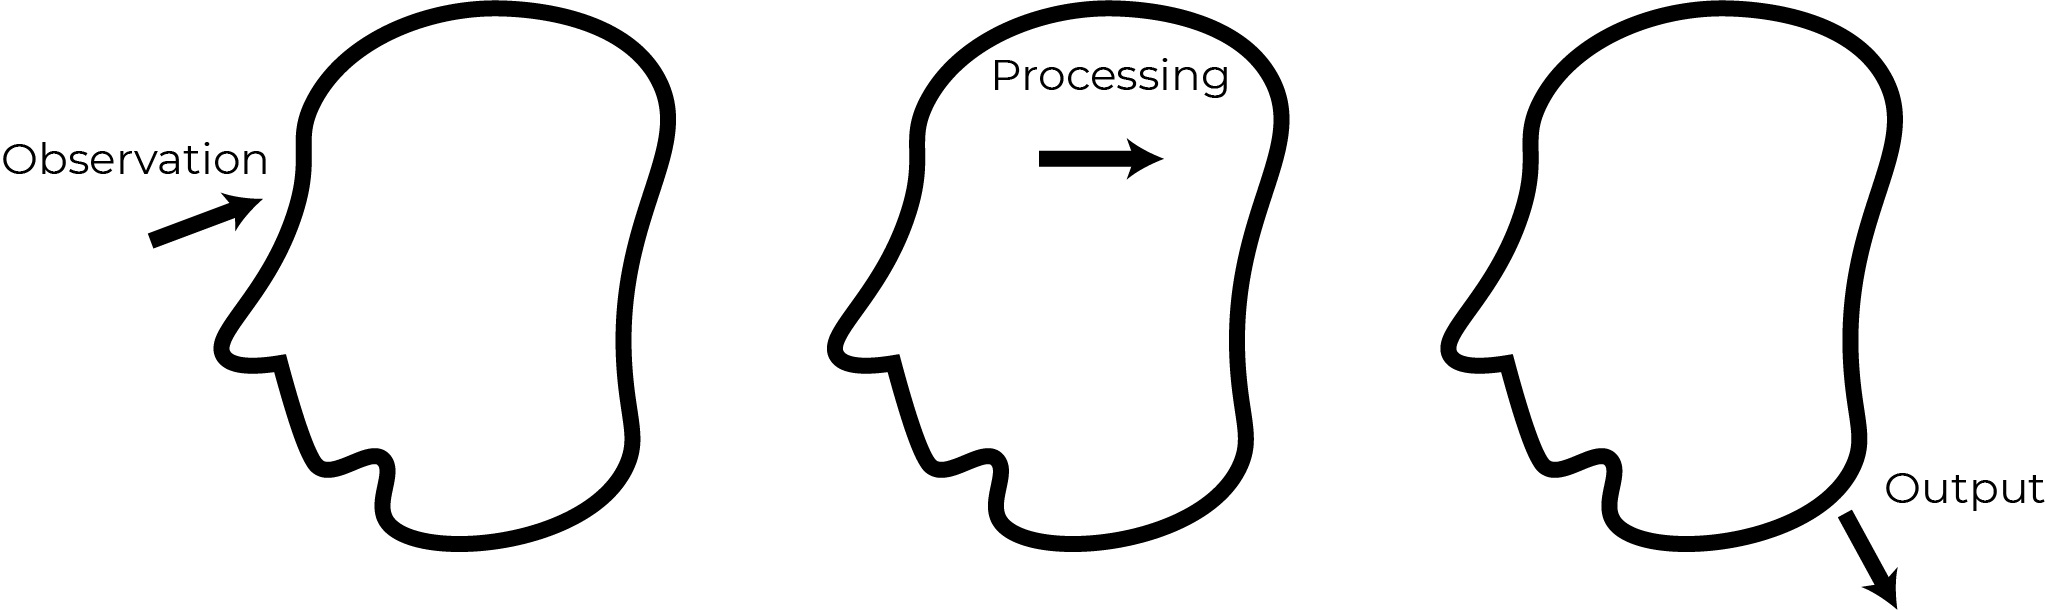

In [51]:
ipythondisplay.Image("https://github.com/BenHals/GeneticPong/raw/main/Processing.png")

This processing step happens as electrical signals in your brain.

1. Observations are converted into electric signals from, e.g., your eyes
2. These electrical signals travel into your brain though your nerves
3. These signals are processed by special cells in your brain called ***Neurons***
4. The Neurons in your brain output a processed signal back into your nervous system
5. The output signal travels to a muscle in your body to perform an action

Lets again look a little deeper at step 3, what are neurons and how to they process the input signals from your eyes into the correct action for your muscles to make?

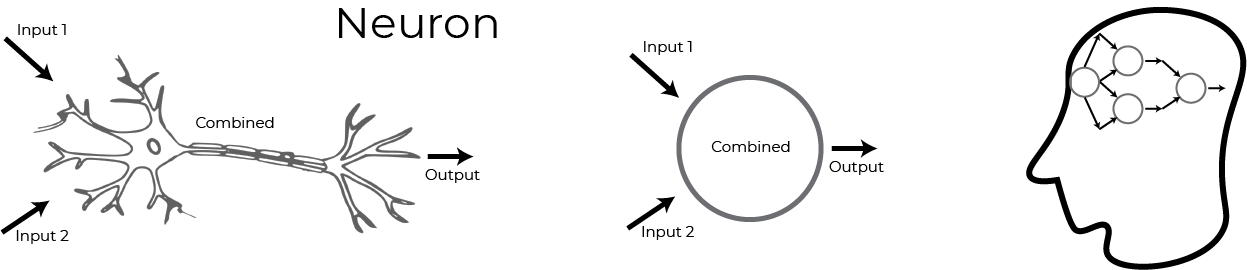

In [52]:
ipythondisplay.Image("https://github.com/BenHals/GeneticPong/raw/main/Neuron.png")

Neurons (on the left in the above image) essentially take multiple input signals, and combine them into an output. A simplified view is shown in the middle image.
Your brain is a *network* of neurons connected together, with signals flowing between them.

The input from your senses flows into the first layer of your brain, gets combined and flows onto the next layer. Eventually, the final layer of neurons produces a signal to your muscles. (Though this is very simplified!)

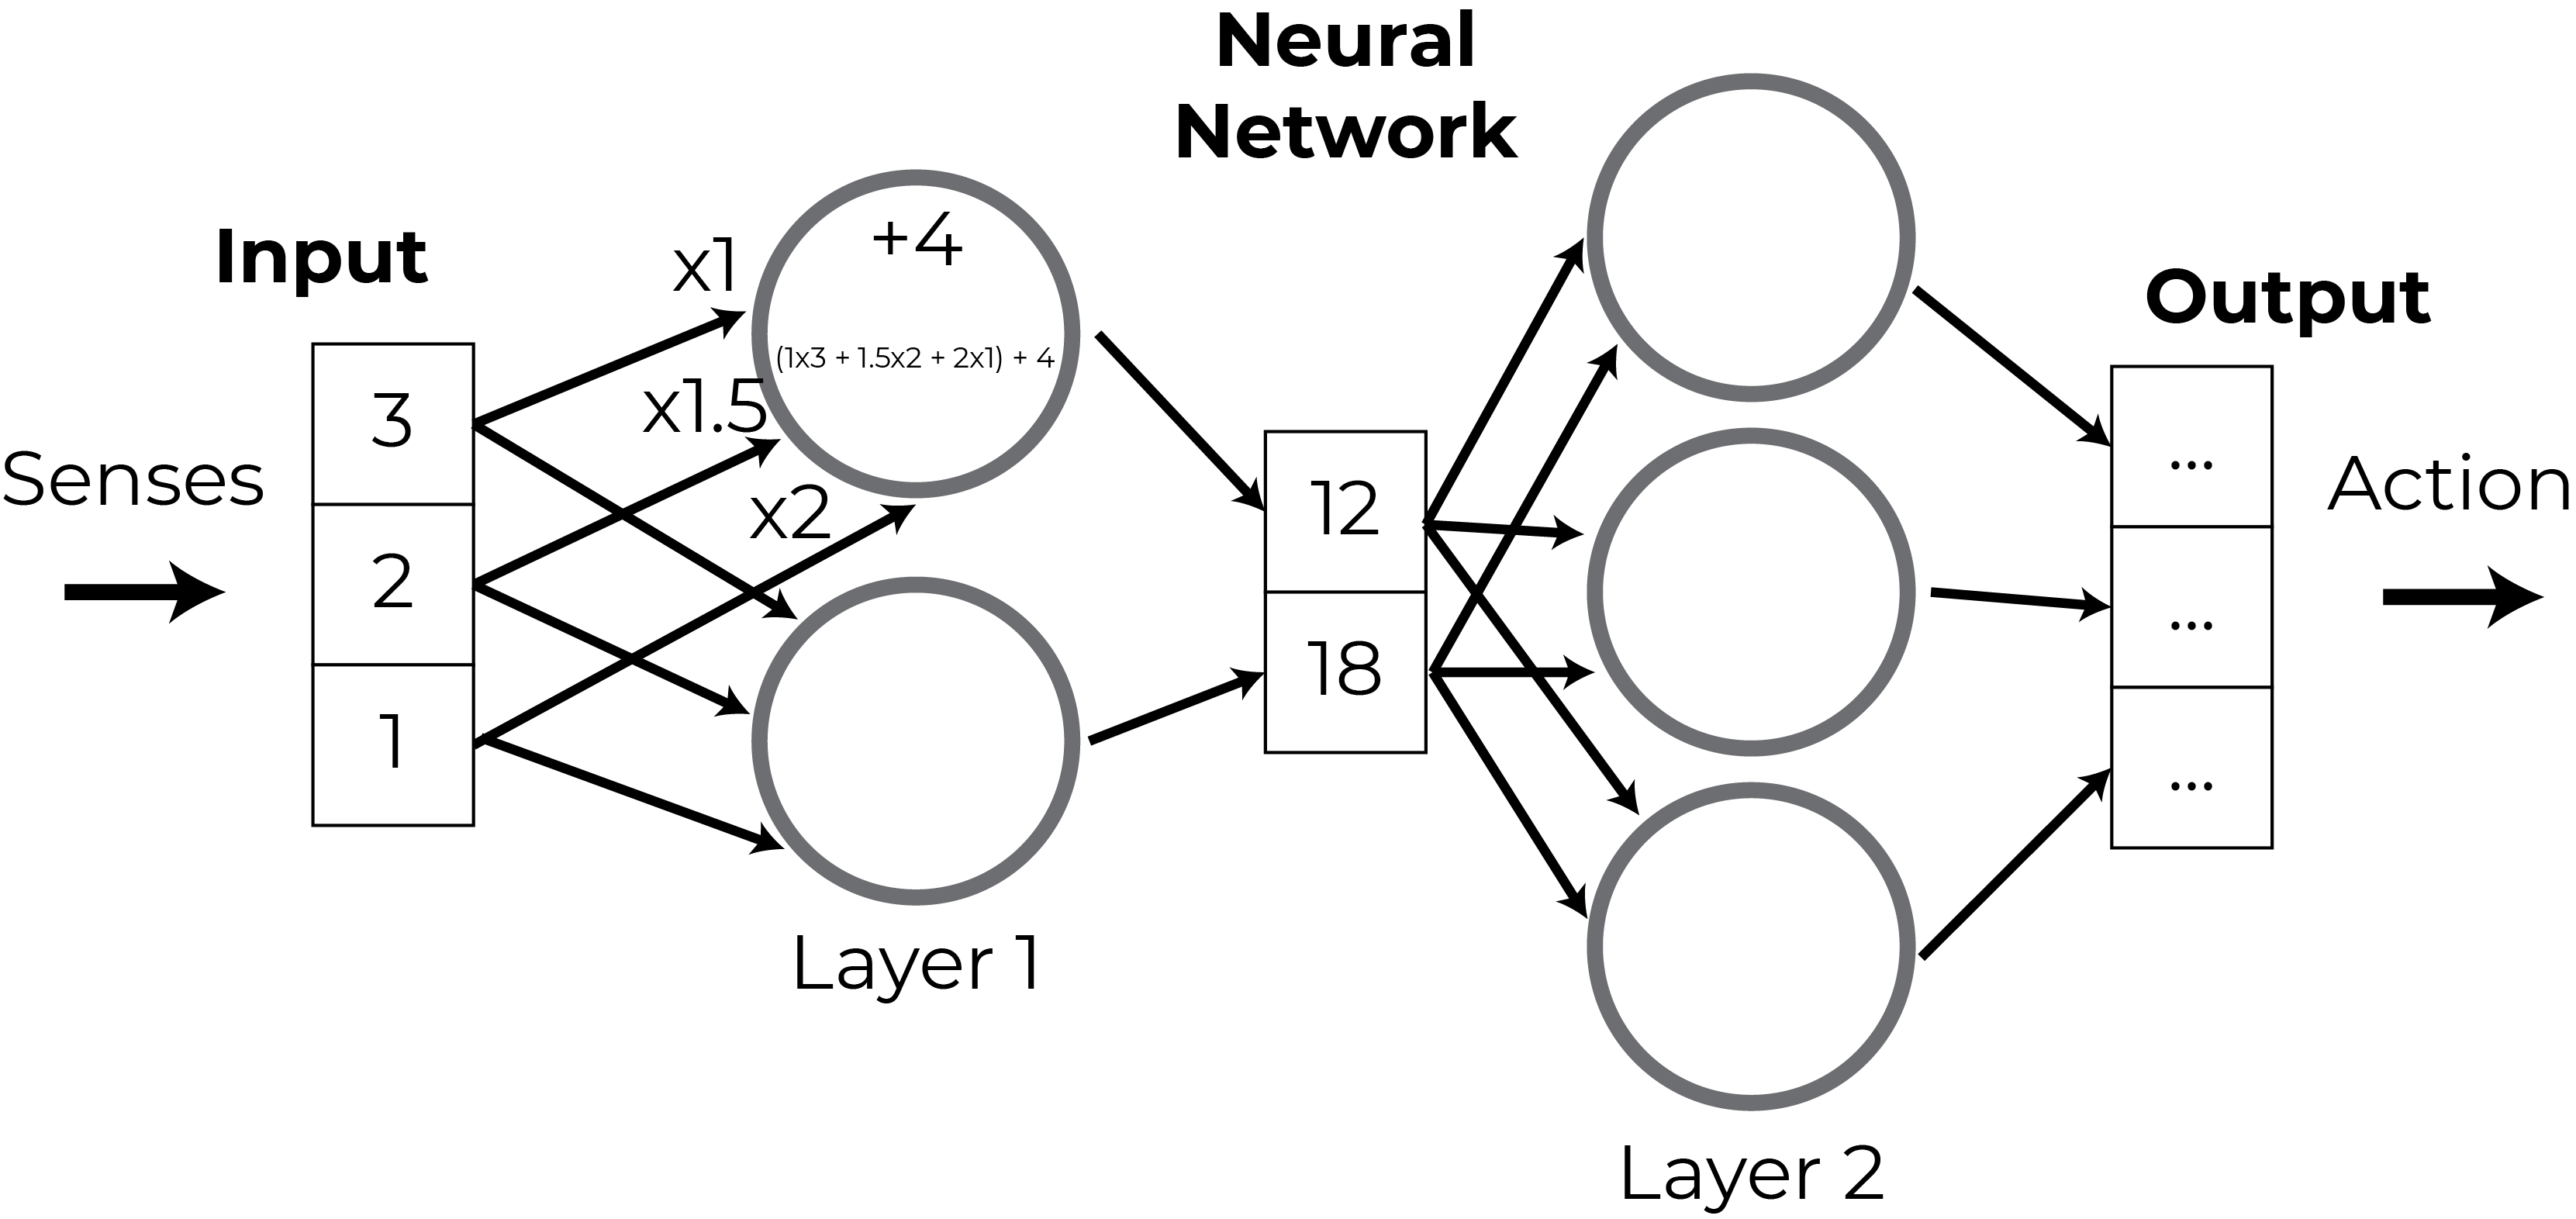

In [53]:
ipythondisplay.Image("https://github.com/BenHals/GeneticPong/raw/main/NeuralNetwork.png", width=1000)

## An Artificial Brain

We are going to simulate a human brain using a model known as a ***Neural Network***. This should sound familiar, a *network* of *neurons*, like what we just looked at in the human brain!

Basically, we are going to model layers of neurons connected together. The input data will be a list of numbers. This will be the input to the first layer of neurons. Each neuron will take the input list, and combine it into a single value. The output of all the neurons in the layer will form a *new* list, whichj will be the input to the next layer! The output from the last layer will be the action that we pass to the game.

Lets look at an example, shown in the image above:

1. We are given an input list, `[3, 2, 1]`
2. We have two Neurons in our first layer, N1 and N2
3. N1 processes the input list:
  - The elements are added together, each with a *weight* representing the strength of the connection: w<sub>1</sub>3 + w<sub>2</sub>2 + w<sub>3</sub>1
  - Then a *bias* is added, representing the output strength of the neuron: (w<sub>1</sub>3 + w<sub>2</sub>2 + w<sub>3</sub>1) + b
  - if w<sub>1</sub> = 1, w<sub>2</sub> = 1.5, w<sub>3</sub> = 2 and b = 4
  - Output = 1x3 + 1.5x2 + 2x1 + 4 = 12
4. N2 processes the input list as well, using *different* weights and biases, simulating a different neuron.
  - Lets say its output is 18

5. The output from this layer is the list [12, 18]

6. [12, 18] is used as the *input* the the next layer of 3 neurons.

7. This layer produces three outputs, one per neuron. 

8. This final output is used to select the action taken by the player. For example, the top number could represent how much to move the pong paddle up, the middle number could represent staying still, and the bottom number could represent how much to move the paddle down.

This is all we need to simulate a brain!




### Lets implement a neuron in code!

In [54]:
class Neuron:
    """ A simple linear neuron.
    Contains a bias, and a list of connection weights, 1 per input.
    """
    def __init__(self):
        self.connection_weights = []
        self.bias = None
    
    def add_connection(self, weight):
        self.connection_weights.append(weight)
    
    def set_bias(self, bias):
        self.bias = bias
    
    def get_output(self, input_signal):
        if len(input_signal) != len(self.connection_weights):
            raise ValueError("Size of input different to size of connection!")

        # The output signal for a neuron is the sum of the signals received from connected
        # input neurons. Each input signal is multiplied by a weight, you could think of this as
        # the influence of that input. In a real brain, this could represent the conductivity of the nerve connection.
        output_signal = 0
        for input, weight in zip(input_signal, self.connection_weights):
            output_signal += input * weight
        
        # Then we add the bias, some extra bit of output signal this neuron always adds to its output
        output_signal += self.bias

        return output_signal
    
    # The following code just allows saving and loading the model
    # Feel free to ignore!
    def to_json(self):
        data = {
            "bias": self.bias,
            "weights": self.connection_weights
        }
        return json.dumps(data)
    
    def from_json_str(self, json_str):
        json_data = json.loads(json_str)
        self.bias = json_data["bias"]
        self.connection_weights = json_data["weights"]

Lets test our neuron by recreating N1 from the previous example

In [55]:
neuron = Neuron()

neuron.set_bias(4)
neuron.add_connection(1)
neuron.add_connection(1.5)
neuron.add_connection(2)

assert neuron.get_output([3, 2, 1]) == 12

Lets plot what our neuron looks like:


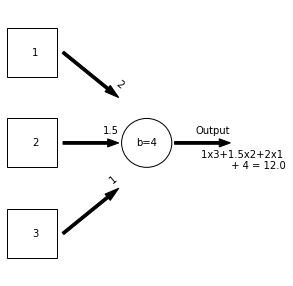

In [56]:
from utils import show_neuron

show_neuron(neuron, [3, 2, 1])

Can you figure out how to make N2? What bias and connection weights work to produce 18 from the given input?

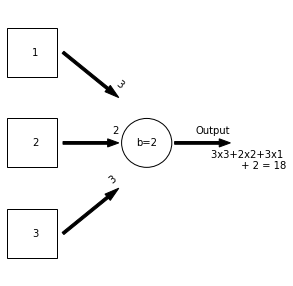

In [57]:
neuron_2 = Neuron()

# One possibility
neuron_2.set_bias(2)
neuron_2.add_connection(3)
neuron_2.add_connection(2)
neuron_2.add_connection(3)

assert neuron_2.get_output([3, 2, 1]) == 18


show_neuron(neuron_2, [3, 2, 1])

We just saw that we can produce an output that we want for some given input, by setting the weights and bias of the neuron! These are called the *parameters*

We can do the same thing to play a game! Given some set of inputs, we need to set the weights and bias of a Neural Network to give the output for the action we want.

For example, if the input we see is [0.2, 1.0, 0.1, 1.0, 0.0] which may indicate that the ball is 0.2 of the screen away, at height 0.1 with direction 1.0 in the x axis and 0.0 on the y axis (coming sideways), and our paddle is at height 1.0. 

We need to move *down* to hit the ball! So out desired output is something like [0.0, 0.0, 1.0], corresponding to the action *move the paddle up*.

Lets see what our pong player thinks:

In [58]:
pong_player.getOutput([0.2, 1.0, 0.1, 1.0, 0.0])

[-2.9704856084915163, -6.30354017031462, 7.240922356131549]

We should get some output with the largest number in the last position. The pong game takes the output with the largest number as the action, so this will correspond to moving the paddle down. 

Did the AI get it right?

Lets plot the network to see how this decision was made:

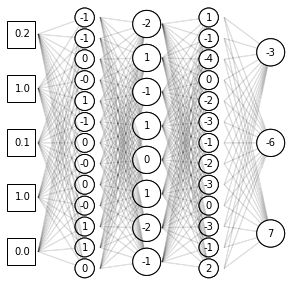

In [59]:
from utils import show_network

show_network(pong_player, [0.2, 1.0, 0.1, 1.0, 0.0])

Our pong player has 4 layers, with 14 neurons, 8 neurons and 14 neurons each. Then a final output layer with 3 neurons corresponding to the 3 possible actions.

While the numbers in the first 3 layers seem pretty random, they work together to transform the input into the correct output.

### Lets implement the Neural Network

Our AI player is a Neural Network, and we have just implemented a Neuron so far.

Lets put some Neurons together into a Network!

Fill in the following Neural Network class, making use of the Neuron you just made. Just set the weights and biases to random values for now.

In [60]:
class NeuralNet:
    """ Represents an 'artificial brain', made up of neurons.
    """
    def __init__(self, nodeCount):
        """Arguments:
            nodeCount: List[int] 
                - A list of ints representing the sizes of each layer of the neural network.
                The first value should be the size of the input layer, and the last value should be the size
                of the output layer. The rest is up to you! More layers, and wider layers, can represent more
                complex interactions, but may also need more time to train because there are more numbers to 
                select and get right. 
            seed: int
                - Controls the random initialization of parameters. Setting the same seed should generate the same
                network. Useful for reproducibility, but can leave as None to just generate randomly.
        """

        self.nodeCount = nodeCount

        # Stores the fitness of the neural network.
        # Set externally by some evaluation function    
        self.fitness = 0.0

        # Generate random neurons to connect in the brain
        self.neuron_layers = []
        for i in range(1, len(nodeCount)):
            neuron_layer = []
            layer_n_neurons = self.nodeCount[i]
            for neuron_index in range(layer_n_neurons):
                # Create our new neuron
                neuron = Neuron()

                # Set a random bias
                neuron.set_bias(np.random.uniform(low=-1, high=1))

                # Make a connection to each neuron in the previous layer
                # with a random strength
                prev_n_neurons = self.nodeCount[i-1]
                for prev_index in range(prev_n_neurons):
                    connection_weight = np.random.uniform(low=-1, high=1)
                    neuron.add_connection(connection_weight)
                neuron_layer.append(neuron)
            self.neuron_layers.append(neuron_layer)
  
    def getOutput(self, input):
        """ Get the output of the neural network given some input
        """
        layer_input = input

        # Output is calculated layer by layer.
        # We calculate the output of the first layer of neurons given the input.
        # We then feed the output of the first layer as input to the second.
        # Repeats until we have gone through all layers, and we can just return.
        for layer in self.neuron_layers:
            layer_output = []
            for neuron in layer:
                neuron_output = neuron.get_output(layer_input)
                layer_output.append(neuron_output)
            # Set output to be input to the next layer
            layer_input = layer_output
        return layer_output
    

    # The following code just allows saving and loading the model
    # Feel free to ignore!
    def to_json(self, fn):
        nn_data = {
            "fitness": self.fitness,
            "nodeCount": self.nodeCount,
            "neurons": [[n.to_json() for n in layer] for layer in self.neuron_layers],
        }
        with open(fn, 'w+') as f:
            json.dump(nn_data, f)
    
    def from_json(self, fn):
        with open(fn, 'r') as f:
            nn_data = json.load(f)
        self.from_json_data(nn_data)

    def from_json_str(self, json_str):
        nn_data = json.loads(json_str)
        self.from_json_data(nn_data)

    def from_json_data(self, nn_data):
        self.fitness = nn_data["fitness"]
        self.nodeCount = nn_data["nodeCount"]
        nn_layers = nn_data["neurons"]
        self.neuron_layers = []
        for layer in nn_layers:
            nn_layer = []
            for n in layer:
                neuron = Neuron()
                neuron.from_json_str(n)
                nn_layer.append(neuron)
            self.neuron_layers.append(nn_layer)

Great, lets test out our Neural Network class, by trying it on the pong input

In [61]:
# We'll make it the same size as the pong player
NN = NeuralNet([5, 14, 8, 14, 3])

output = NN.getOutput([0.2, 1.0, 0.1, 1.0, 0.0])
print(output)

[17.709974378377627, -9.269444631189087, 4.682057023685958]


Hmm we don't seem to be getting the right output. Why is this? Lets plot it

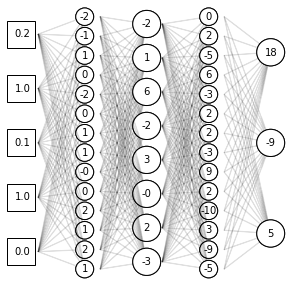

In [62]:
show_network(NN, [0.2, 1.0, 0.1, 1.0, 0.0])

Even though the network seems similar, the output it produces is wrong.

Right now, our artificial brain is just random!
We need to *teach* it to produce the right outputs for each input!

We'll do this using the power of *Evolution*!

# Evolving a Pong Player

So we have seen that a brain processes input signals into output signals.

And a *good* brain is one with parameters that produce the correct output signals for the given inputs.
 (correct being the outputs that play pong well!)

 Right now we just have random parameters, which probably don't play pong very well (or, since it is random, maybe your one does play pong well just by chance!)

***How to we find a set of parameters which can play pong?***

## Genetic Evolution

Again, lets take inspiration from the natural world, specifically, Evolution!

Evolution is a process where a *population* improves over time through *survival of the fittest*.

We are going to simulate this process to find AI brains which can play pong, eventually, leaving us with adept pong players!
This process is called a ***genetic algorithm***, because it simulates how real life genetics works.

This is the basic process:

1. We create a *population* of random individuals, each described by a genome (e.g., DNA for humans)
  - How can we describe our Neural Network as a genome?
  - (Hint: We loaded a saved model before to play, what values did we need for that?)
2. The population is simulated for a period of time, and the *fitness* of each member is evaluated
  - The fitness is a score, or reward, which measures how well that individual performed. In animals, this could be how many children they had, for our pong players it might be their score in game.

3. Once fitness is recorded, the next *generation* of the population is created.
Some members *survive*, and are carried through into the next generation, while some *die off*. The surviving individuals become parents of the next generation, combining their genomes to produce new members with similar properties.
  - Mutations are also introduces, so that new members behave *slightly* differently

4. We repeat this process for many generations! The population becomes better overtime. Why?
  - Members are random at the start, while probably none will be able to actually play pong at the start, some will be better than others, i.e. hit the ball by chance.
  - Poorly performing members die off, while better members will survive, passing on the parameters which let them hit the ball
  - If two members hit the ball in different ways, i.e., one figured out moving up and the other figured out moving down, then their child might be able to do both!




## Lets create a population

Lets start off by constructing a population of random Neural Networks, and getting them to play.

We will record their scores, or fitness, and view how the best one did.

In [63]:
class Population :
    def __init__(self, populationCount, mutationRate, nodeCount):
        """ Generates a population of random neural networks
        Arguments:

          populationCount : int
            - The number of neural networks to generate
          

        """
        self.nodeCount = nodeCount
        self.popCount = populationCount
        self.m_rate = mutationRate

        # Not neccessary, just to make this code general
        self.neural_net_class = NeuralNet

        self.population = [ self.neural_net_class(nodeCount) for i in range(populationCount)]

# Lets make a population of 100, with a mutation rate of 0.01, with the same shape as before
pop = Population(100, 0.01, [5, 14, 8, 14, 3])

Lets pick some random members, and see what they look like

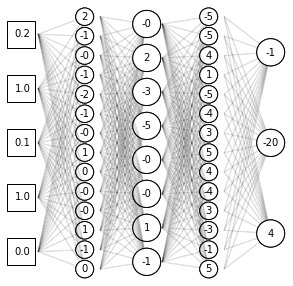

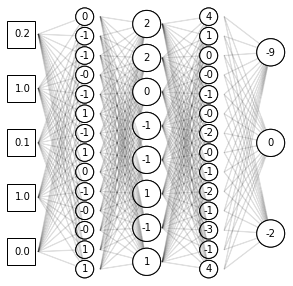

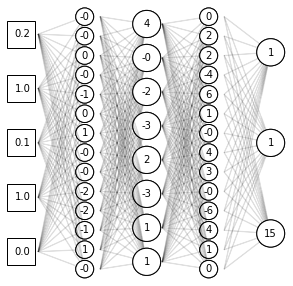

In [64]:
for i in range(3):
  member = np.random.choice(pop.population)
  show_network(member, [0.2, 1.0, 0.1, 1.0, 0.0])

Each one has *random* weights and biases, so produces different outputs for the same input.

We need to test every member of out population, and give them a *fitness* score based on how well they do.

We can test them by getting them to play pong! But it would take a while to play against all 100 AIs... 

Why don't we get them to play *eachother*?

## AI vs AI

Lets write a function which will play one AI against another

In [65]:
def versus_match(player_left, player_right, max_steps=5000):
    # Setup the game
    # You might notice we don't record here. We will be playing many games
    # so recording would only slow us down!
    env = CustomPong()
    observation_left, observation_right = env.reset()

    # We record the score, or 'reward' for each player
    totalReward_left = 0
    totalReward_right = 0

    # The game is run in steps, where each player gets to pick their action
    for step in range(max_steps):
        # In this pong game, players only get to pick their action every 10 steps
        if step % 10 == 0:
            # The players decides their action based on their senses 'observing' the world
            action_left = player_left.getOutput(observation_left)
            action_right = player_right.getOutput(observation_right)

        # We progress the game one step based on the selected actions of each player.
        # The game sends back the next observation each player makes, as well as their rewards
        (observation_left, observation_right), (reward_left, reward_right), done, info = env.step((action_left, action_right))
        totalReward_left += reward_left
        totalReward_right += reward_right
        if done:
            break
    return totalReward_left, totalReward_right

And lets test it out:

In [66]:
left_AI = np.random.choice(pop.population)
right_AI = np.random.choice(pop.population)

left_reward, right_reward = versus_match(left_AI, right_AI)
print(f"Left player got a reward of {left_reward}, right player got a reward of {right_reward}")

Left player got a reward of -1.3561753001461034, right player got a reward of 0.29490602394823556


Hmm both rewards seem pretty low, lets have a look at what is happening using out record function from earlier

In [67]:
recordPongGame(left_AI, right_AI)
show_video()


 Recording Game
---------------------
Game Finished! Left got a score of -1.7084143775849485, Right got a score of 0.21880437023103616


Our random players don't do so well! This is probably expected...

Lets go ahead and test them all:

In [68]:
def evaluate_population(pop, n_tests=5):

  # We will be playing a few games with each member, so lets create a record of the rewards they earn
  reward_record = {}

  # Initialize records for each member
  for pop_i, nn in list(enumerate(pop.population)):
    reward_record[pop_i] = []

  # We create a random order to handle matchups
  availiable_opponents = list(range(len(pop.population)))
  np.random.shuffle(availiable_opponents)

  # We are going to test each AI n_tests times
  for i in range(n_tests):
    print(f"Test {i}")
    # Loop testing each member of the population
    for pop_i, nn in list(enumerate(pop.population)):

      # lets get the record for games this AI has already played
      member_record = reward_record[pop_i]

      # We may have played all required games as an opponent!
      if len(member_record) >= n_tests:
        continue

      # Select a new opponent, which hasn't already played all its matches
      opponent_i = availiable_opponents[-1]
      opponent = pop.population[opponent_i]
      opponent_record = reward_record[opponent_i]

      reward_member, reward_opponent = versus_match(nn, opponent)

      member_record.append(reward_member)
      opponent_record.append(reward_opponent)

      # Take the opponent off availiable_opponents if it has played enough matches
      while len(availiable_opponents) > 0 and len(reward_record[availiable_opponents[-1]]) >= n_tests:
          availiable_opponents.pop()
  
  min_pop_fitness = 100000
  max_pop_fitness = -100000
  avg_pop_fitness = 0
  best_player = None
  # Now lets set the fitness of each AI to be its average score
  for pop_i, nn in enumerate(pop.population):
        rewards = reward_record[pop_i]
        avg_reward = np.mean(rewards)
        nn.fitness = avg_reward

        # And track min, max and avg of the population
        min_pop_fitness = min(min_pop_fitness, nn.fitness)
        avg_pop_fitness += nn.fitness
        if nn.fitness > max_pop_fitness :
            max_pop_fitness = nn.fitness
            best_player = nn
  avg_pop_fitness /= len(pop.population)
  return min_pop_fitness, avg_pop_fitness, max_pop_fitness, best_player


In [69]:
pop = Population(100, 0.01, [5, 14, 8, 14, 3])
min_pop_fitness, avg_pop_fitness, max_pop_fitness, best_player = evaluate_population(pop)
print(f"Min fitness: {min_pop_fitness}, Max fitness: {max_pop_fitness}, Avg fitness: {avg_pop_fitness}")

Test 0
Test 1
Test 2
Test 3
Test 4
Min fitness: -1.5928523200353455, Max fitness: 0.35963058320495267, Avg fitness: -0.8479949821386721


And lets have a look at the best overall player:

In [70]:
recordPongGame(best_player, best_player)
show_video()


 Recording Game
---------------------
Game Finished! Left got a score of -1.2823913963233835, Right got a score of 1.470862649886962


The best player from this generation should be begining to look like a pong player, but will probably still be pretty bad. 

How can we find a better AI?

One option is to generate a totally new, random population. You can try this out by rerunning the cell 2 steps back to make a new population and evaluate it. We could just generate random players until one is good, purely by chance!

But this would be pretty slow. (How many different possible AIs are there? Think about it!)

What we want to do instead, is take the *best* members from our current generation, and base the next generation off of them! This way, we are more likely to generate good members.

This is *Evolution*!


## Build an AI Family

The first thing we need to do is be able to combine the properties of two good AIs.

In other words, take to *parents* and produce a *child*. 

We also want a change some some random change occuring, so the child may improve on its parents.

Lets write a function to take two parent neural networks, and produce a child.

In [71]:
    def try_mutate_value(mutated_value, m_rate, parent1_value, parent2_value, parent1_fitness, total_fitness):
        """ A helper function while takes a random mutated value, as well as values from two parents, and randomly selects which to return.
        The chance of returning each value is based on a mutation rate, as well as the fitness of each parent, i.e., the better parent is more likely
        to pass on its genes.
        """
        # Check if a mutation occured
        mutation_roll = np.random.rand()
        mutation_occured = mutation_roll < m_rate
        if mutation_occured:
            return mutated_value

        # If a mutation did not occur, We need to inherit a value from a parent
        # We pick the parent based on the fitness of each parent,
        # i.e., a parent with a higher fitness is more likely to pass
        # on its value
        inherit_from_p1_roll = np.random.rand()
        p1_proportion_of_fitness = parent1_fitness / total_fitness
        inherit_from_p1 = inherit_from_p1_roll < p1_proportion_of_fitness
        if inherit_from_p1:
            child_value = parent1_value
        else:
            child_value = parent2_value
        return child_value


    def createChild(nn1, nn2, mutation_rate):
        """ Create a child neural network by combining two NeuralNets
        """
        # Create a new completely random neural network
        # Each parameter here represents a 'mutation'
        child = NeuralNet(nn1.nodeCount)

        # Now we are going to adjust some of the neurons to inherit from the parents
        total_fitness = nn1.fitness + nn2.fitness
        all_child_neurons = [n for layer in child.neuron_layers for n in layer]
        all_parent1_neurons = [n for layer in nn1.neuron_layers for n in layer]
        all_parent2_neurons = [n for layer in nn2.neuron_layers for n in layer]

        
        for i, child_neuron in enumerate(all_child_neurons):
            parent1_neuron = all_parent1_neurons[i]
            parent2_neuron = all_parent2_neurons[i]
            # The current data in the child is completely random, i.e., represents 'mutated' data
            # We want to keep this randomness with probability of mutation_rate
            # For bias and each connection weight, we either keep the mutated value or inherit from a parent.

            bias = try_mutate_value(child_neuron.bias, mutation_rate, parent1_value=parent1_neuron.bias, parent2_value=parent2_neuron.bias, parent1_fitness=nn1.fitness, total_fitness=total_fitness)
            child_neuron.set_bias(bias)

            parent1_weights = parent1_neuron.connection_weights
            parent2_weights = parent2_neuron.connection_weights
            for w, mutated_weight in enumerate(child_neuron.connection_weights):
                weight = try_mutate_value(mutated_weight,mutation_rate, parent1_value=parent1_weights[w], parent2_value=parent2_weights[w], parent1_fitness=nn1.fitness, total_fitness=total_fitness)
                child_neuron.connection_weights[w] = weight

        return child

Lets try to make a child neural network from the best two members of our population

In [72]:
sorted_population = sorted(pop.population, key=lambda x: x.fitness)

best = sorted_population[-1]
print(f"Best fitness: {best.fitness}")
second_best = sorted_population[-2]
print(f"Second best fitness: {second_best.fitness}")

child = createChild(best, second_best, mutation_rate=0.01)

recordPongGame(child, child)
show_video()

Best fitness: 0.35963058320495267
Second best fitness: -0.003707849508304628

 Recording Game
---------------------
Game Finished! Left got a score of 0.4144085724881328, Right got a score of -0.9176714500007006


Is the child better? Is it worse?

It's purely up to chance, the same as in real life evolution!

We have to run the evolution process over many generations to see improvement.

## Create A New Generation

Lets put everything together, to evolve our current generation of AIs

We are going to create a function, which takes a population, retains the best members (by fitness), and fills up the remaining spots with children.

In [73]:
class Population :
  def __init__(self, populationCount, mutationRate, nodeCount):
      """ Generates a population of random neural networks
      Arguments:

        populationCount : int
          - The number of neural networks to generate
        

      """
      self.nodeCount = nodeCount
      self.popCount = populationCount
      self.m_rate = mutationRate

      # Not neccessary, just to make this code general
      self.neural_net_class = NeuralNet

      self.population = [ self.neural_net_class(nodeCount) for i in range(populationCount)]

  def select_random_parent(self, retained_members):
    fitness = [x.fitness for x in retained_members]
    # We need positive fitness to calculate a probability, so we will just make the minimum value 0
    min_fitness = min(fitness)
    positive_fitness = [f+abs(min_fitness) for f in fitness]
    total_fitness = sum(positive_fitness)

    # Give each member a probability based on its fitness
    probabilities = [f/total_fitness for f in positive_fitness]

    return np.random.choice(retained_members, p=probabilities)
      
  def createNewGeneration(self):    
      nextGen = []
      # Sort out population in terms of fitness
      self.population.sort(key=lambda x: x.fitness, reverse=True)

      # We will retain some proportion of current members as they are
      proportion_retained = 0.25
      n_retained = int(len(self.population) * proportion_retained)
      retained_members = []
      for i in range(n_retained):
            copied = copy.deepcopy(self.population[i])
            retained_members.append(copied);
            nextGen.append(copied)
      
      # Now we want to fill the generation with children.
      # We will randomly select
      while(len(nextGen) < self.popCount):
          parent_1 = self.select_random_parent(retained_members)
          parent_2 = self.select_random_parent(retained_members)
          nextGen.append( createChild(parent_1, parent_2, self.m_rate))
      self.population.clear()
      self.population = nextGen

Lets try making a new generation

In [74]:
pop2 = Population(100, 0.01, [5, 14, 8, 14, 3])

# We'll just start with the population we just evaluated
pop2.population = pop.population

pop2.createNewGeneration()

And lets see if it got any better!

In [75]:
min_pop_fitness, avg_pop_fitness, max_pop_fitness, best_player = evaluate_population(pop2)
print(f"Min fitness: {min_pop_fitness}, Max fitness: {max_pop_fitness}, Avg fitness: {avg_pop_fitness}")

Test 0
Test 1
Test 2
Test 3
Test 4
Min fitness: -1.4561278188120301, Max fitness: 0.8479602698975606, Avg fitness: -0.74278954851719


In [76]:
recordPongGame(best_player, best_player)
show_video()


 Recording Game
---------------------
Game Finished! Left got a score of 0.9833588014551722, Right got a score of -1.0164868134435754


Hopefully this new generation is looking better!

But, just like in real life, evolution really happens over *many* generations, and we only have seen two!

Lets put things together to train many generations of pong players!

## A lineage of Pong

In [77]:
MAX_STEPS = 15000
# Increase this to evolve for more generations!
# Will give better results
MAX_GENERATIONS = 10
POPULATION_COUNT = 50
MUTATION_RATE = 0.02
COMPARISON_TESTS = 10


env = CustomPong()
observation = env.reset()

input_dimensions = 5
output_dimensions = 3

# We first create a population of neural networks.
# For each generation, the neural networks play eachother, recording their performance into reward_map
# Once we have the fitness scores for all NNs, we evolve a new generation. We randomly select some NNs to pass into
# the next generation, with better performing NNs being more likely.
# We then fill the rest of the generation with children, which inherit from randomly selected parents.
pop = Population(POPULATION_COUNT, MUTATION_RATE, [input_dimensions, 13, 8, 13, output_dimensions])

for gen in range(MAX_GENERATIONS):
    min_pop_fitness, avg_pop_fitness, max_pop_fitness, best_player = evaluate_population(pop, n_tests=COMPARISON_TESTS)
    print(f"Generation: {gen} | Min: {min_pop_fitness} | Max: {max_pop_fitness} | Avg: {avg_pop_fitness}")

    # Create New Generation!
    pop.createNewGeneration()

Test 0
Test 1
Test 2
Test 3
Test 4
Test 5
Test 6
Test 7
Test 8
Test 9
Generation: 0 | Min: -1.3651044463184396 | Max: -0.2485546743996502 | Avg: -0.8685686564541822
Test 0
Test 1
Test 2
Test 3
Test 4
Test 5
Test 6
Test 7
Test 8
Test 9
Generation: 1 | Min: -1.2814908995493473 | Max: 0.05491117556217582 | Avg: -0.8262908323102327
Test 0
Test 1
Test 2
Test 3
Test 4
Test 5
Test 6
Test 7
Test 8
Test 9
Generation: 2 | Min: -1.4604878473243372 | Max: -0.050469639622980435 | Avg: -0.7848312201883991
Test 0
Test 1
Test 2
Test 3
Test 4
Test 5
Test 6
Test 7
Test 8
Test 9
Generation: 3 | Min: -1.2729786909818357 | Max: 0.1744905682256079 | Avg: -0.8150828918112297
Test 0
Test 1
Test 2
Test 3
Test 4
Test 5
Test 6
Test 7
Test 8
Test 9
Generation: 4 | Min: -1.4599757683556054 | Max: 0.16569073989899136 | Avg: -0.7318210626088495
Test 0
Test 1
Test 2
Test 3
Test 4
Test 5
Test 6
Test 7
Test 8
Test 9
Generation: 5 | Min: -1.3673245229317188 | Max: 0.39446347697768486 | Avg: -0.703739546792396
Test 0
Tes

Note: Do we expect to see the fitness of the population increase over time?

Maybe, but not too much! The fitness score in pong depends on how well you play relative your opponent. Our AIs are playing eachother, so as they get better, their opponents ***also*** improve!



In [78]:
recordPongGame(best_player, best_player)
show_video()


 Recording Game
---------------------
Game Finished! Left got a score of 0.4878642120643455, Right got a score of 0.012135787935710511


After some generations, the players should be playing pretty well!

You have created your own AI!


# Learning to Walk

Is this approach specific to Pong? Can we evolve brains to do other things as well?

Lets look at a task closer to something we might see in the real world, like walking!

Again, we are going to start with a demo, we loading a pretrained set of neurons into the SAME neural network class we already made!

In [79]:
# We will create an empty Network, all parameters will be loaded in
walker = NeuralNet([1])

walker.from_json_data({"fitness": 183.64688517697056, "nodeCount": [24, 13, 8, 13, 4], "neurons": [["{\"bias\": -0.8797819915619194, \"weights\": [0.24118450647886802, -0.46455812450934686, 0.597923868944281, 0.7500618576212195, -9.343551852580845e-05, -0.037388483051385535, 0.5172647718609771, 0.6223254342307116, 0.06499186189577788, 0.13233799983877237, -0.656567458280257, 0.9638924346912323, -0.06822416036146128, -0.6136062222645446, 0.7029122468522864, 0.5344308881755273, -0.3381352709421208, 0.007291678919687294, 0.12886130300105614, -0.6546153314711598, -0.3535940852961723, 0.8949294705543742, 0.9246203454187221, -0.7391727140905184]}", "{\"bias\": -0.7843044664535284, \"weights\": [0.21125188328618605, -0.7503132612054084, -0.5663379774438744, 0.73357585985637, -0.9127074132560429, 0.18335285163981307, -0.9258683331355388, -0.012406463315876692, 0.8517754652054483, -0.7328274401362025, -0.006093516311063807, -0.4227303117490828, -0.42638707598953873, -0.5014066922542713, -0.9872796498700305, -0.5123657959906776, 0.08227402039747855, 0.9632662334410815, -0.2862353067188297, 0.4984612844129608, -0.35968839228074456, 0.9378954455763366, -0.044513777658292675, -0.9409225792545501]}", "{\"bias\": -0.34361540366308274, \"weights\": [0.5149640622813452, -0.3190468454011848, 0.26249800155806824, 0.9130718605811574, -0.06427909032074752, 0.6569510831457421, 0.02691968924180599, 0.8718506256916136, 0.27882698612220413, -0.1426608206041291, -0.152271785379974, -0.030989131891810517, 0.16409389784500172, -0.5127223300224428, -0.1682445359527167, -0.3329019506754136, 0.07533101291028044, 0.3607638804973663, -0.8790940053408154, -0.9784224602519447, 0.8976550752241119, -0.8421877999743017, -0.6819370722774636, 0.6360159696945118]}", "{\"bias\": 0.4408395158234093, \"weights\": [-0.1946466151303483, 0.7232829507537575, 0.39090099444743176, 0.7534100515754889, -0.6229508426246619, -0.7593705448459729, 0.27064592226424455, -0.6329144277474328, -0.6667638825794369, -0.7111986356494309, -0.6740902583643673, -0.6996162690434009, -0.4896864533899148, -0.2433465855372563, -0.7712660282680872, 0.8598932131742858, -0.9990458709445125, -0.4317396012735859, 0.3101833194845589, 0.30299526121790077, -0.3786972586924717, 0.22558291865611446, -0.871601268363474, 0.9015403021901016]}", "{\"bias\": -0.5068732443517803, \"weights\": [-0.6733050801865479, -0.1750265985384798, 0.6609759750039244, 0.10884271691011627, 0.6859625419483526, 0.6743110304083852, -0.9577906912934413, -0.04315275888616332, 0.6805922925063423, -0.7504980687009564, -0.904606484732879, -0.37091773932664185, -0.46605453512646644, 0.2265973290847043, -0.24434049213921827, -0.3600633360820391, -0.4651149919888147, 0.6801848848927179, -0.00010145588046839293, 0.74738164602279, 0.07316241760106568, 0.2758652530119772, 0.07881563343369336, 0.3732069110725642]}", "{\"bias\": 0.8950589325024223, \"weights\": [-0.21976484446508215, 0.6164103632988376, -0.731156907180111, 0.7196780457526799, 0.030491977906352608, 0.1572732195722697, 0.5578280417570176, -0.5623395836788772, 0.5318583951561424, -0.27967300933130956, -0.23709873602294662, -0.6757049180442949, -0.39988822213160335, 0.4219703547534992, 0.3140347892466957, 0.568079481919205, 0.420440417584274, -0.474996846754282, 0.4216550511124981, 0.7680921010320982, -0.42713026945106813, -0.9290317418523717, 0.88507361161081, -0.03783086338169661]}", "{\"bias\": -0.6832530347814263, \"weights\": [0.029083967087888185, -0.6630787141525585, 0.5986035358144222, 0.3976110978548417, 0.6245755462312457, -0.15451064129029324, -0.7438859319794671, 0.20939009474484438, -0.2884074344309633, -0.36784403466871973, -0.724975996599005, -0.14571688408535532, -0.12926283380930315, -0.13256701514776603, 0.06877393780586227, 0.3379132258045867, -0.7678011682331187, -0.5349621650558385, 0.28110354655237346, 0.4480786366113714, -0.8888311219625666, 0.8986527417051977, 0.4666941751881266, 0.201741728036281]}", "{\"bias\": -0.14222832296516041, \"weights\": [-0.7298944528021252, -0.08569373919376333, 0.8778261293191434, 0.28920993968992836, 0.24107726610374502, -0.6883072914328714, -0.2725009220381569, -0.6394323238911652, -0.37540451852067136, -0.522059944709889, -0.31059144795035665, 0.589386139704676, -0.19662108233482867, 0.11839956266988194, -0.6837538202841829, 0.5279871022952236, -0.07941671533475847, 0.8026203929873457, -0.3567692332597432, 0.49666618858538025, 0.1568546187661921, 0.1590517186884779, 0.42225134399842035, -0.8146553741184266]}", "{\"bias\": 0.5606787561129081, \"weights\": [0.8415419690505785, -0.12690891651536096, 0.3682089687733052, -0.5067275777281248, 0.7280947178615675, 0.8525869023411676, -0.19587219115500631, 0.9512651327490764, -0.4205094771158886, -0.547384734262303, 0.38074820064895976, 0.676538544444621, 0.0654432402282652, -0.775257740095574, -0.8993147863635818, 0.10950692868921652, -0.8485957789195335, 0.15600599415019611, -0.739475218225752, 0.9463952862012464, -0.29250815680847375, 0.7156947884352312, -0.35687659823224505, 0.9731056156754898]}", "{\"bias\": -0.7068078735776078, \"weights\": [0.5963935309837542, -0.9940410589547692, 0.011187368584886892, -0.8686764411373513, -0.9047962825859803, -0.7903072588140747, -0.29179599641697496, 0.32262187107210627, 0.40765663023713583, -0.22730116081509588, -0.2751817087727171, -0.4200362167223439, 0.7958458455346089, -0.1480666174392231, -0.23131861355756622, -0.9081906446729466, 0.06824670536515742, -0.7850253370409521, 0.8682183844815003, -0.26763057705210125, 0.1635407854253832, -0.9890382755105487, 0.029945237157815052, 0.30022981833838247]}", "{\"bias\": -0.6664386823312343, \"weights\": [0.9345425615125074, -0.13174840298452684, -0.18516115354859042, -0.7315187250296078, 0.20711471214749144, -0.07801544436559049, 0.9220178178576104, 0.31498624791412766, 0.17477539498353623, 0.4381459827055749, -0.174593699541147, -0.5690000474729697, -0.7778759725412006, -0.9601462821639095, 0.1613381588559344, 0.03357701335100072, -0.551697881904339, -0.16022318645376443, -0.04321282272855864, 0.5861258975215093, 0.8066089858252274, -0.027122389451793794, 0.9110146549603713, -0.17137335814688304]}", "{\"bias\": -0.4193481152780618, \"weights\": [-0.6747909925142497, 0.0713824203779505, -0.005216667857722568, 0.6739262448724486, -0.5120929666839849, -0.9887663442960584, 0.8686921079193306, -0.930760684122073, -0.49977260926779454, 0.1232529228789443, 0.7820153925821294, 0.9105774157495521, 0.8278437257432683, 0.6215145702098352, 0.47322061982484476, 0.31358625666662476, -0.6961333915172636, 0.09148259596357522, 0.22604843039456424, -0.8092203344874489, -0.71100953139448, -0.24361435923893282, 0.7410813472648026, -0.6624518147587026]}", "{\"bias\": 0.23153965422288203, \"weights\": [0.2434381245435071, -0.2924771203120997, 0.5710268181612952, -0.9072299308715019, -0.8086043804543694, 0.16930102911703027, -0.1537800499431936, 0.010514932453472792, 0.5689637025238838, -0.19356726893169762, -0.39018529360130927, 0.8848961385204135, 0.06442544404625394, 0.5142626244427644, 0.40742171810394257, 0.7928727643619329, -0.14303186332963058, -0.1019137982822158, -0.4769900347865801, -0.8780366548573488, -0.9550064443223354, 0.9934081409365596, -0.8087767468556124, 0.09384895650368064]}"], ["{\"bias\": -0.44345501404712584, \"weights\": [-0.4261508719927509, 0.7108122175546427, 0.4336936506850446, -0.9209375518098892, 0.2730060024021439, -0.294495562750122, 0.2113686899119771, -0.462771023338584, 0.7140717155747931, 0.006765411149507017, 0.8369614368250851, -0.9567548436077988, -0.8928501573905996]}", "{\"bias\": 0.33924643851533687, \"weights\": [-0.4196386802542582, -0.516139827075569, -0.6265826555467586, 0.31717074540844625, 0.8258309452316288, 0.5077736696484785, 0.37526844983672536, 0.9533851215237643, -0.2182782223246953, -0.03711570387753205, 0.8726269139253626, 0.04640048291247001, -0.688453778132128]}", "{\"bias\": -0.9353606411282647, \"weights\": [0.6321196878546631, 0.15084314221292372, 0.793600529410148, -0.8579173847720085, 0.35778532710399036, -0.36399713084291374, -0.8745653621703795, -0.3704809213960669, 0.3804017060108871, 0.7452026108286589, 0.9521969175768039, -0.6564968796820239, -0.8904508396363529]}", "{\"bias\": -0.24195357479431934, \"weights\": [0.8727938780040148, -0.31361496925626, 0.09875644139914197, -0.6032717674251269, 0.8719261522996573, -0.9879072254343784, -0.804516877407274, -0.6329225200282564, -0.06112087958128143, -0.4421568558354634, -0.6333615311200866, 0.37025883400189574, 0.5279360367984638]}", "{\"bias\": -0.7131883995570878, \"weights\": [-0.814333716222567, 0.3412257171334845, -0.8608000408300027, -0.09460475707916105, -0.4713212502675064, 0.19938440716443395, 0.2593175741513485, -0.3092216886350738, 0.4077074411153152, 0.9725117656963327, 0.49300030108596005, -0.4114358850252917, -0.48606372700787737]}", "{\"bias\": 0.5300137334869166, \"weights\": [-0.48113716534998874, -0.1006228485196421, -0.055538122226130415, -0.9340141637248758, 0.7529520953619673, 0.9501937448757409, -0.5330660207006979, 0.6644268860553724, 0.4133032861587218, -0.2310795329800861, 0.5825851062424512, 0.11562024651890357, 0.5165329586639904]}", "{\"bias\": 0.9406488414807854, \"weights\": [0.3818100203399626, 0.507962049771433, 0.964790861588857, 0.6218506986690071, -0.2442523710408564, -0.4883193073038419, 0.6117792147971763, -0.9757771042456134, 0.6943199156313069, 0.06831486877451387, 0.7898560571750102, -0.3731011565259894, 0.6789735514575483]}", "{\"bias\": 0.13125189010365412, \"weights\": [-0.40056326223106775, -0.558297292718996, -0.2044845948656262, -0.12984735058076802, 0.4697454905691987, -0.7111666668603243, 0.604608762791313, -0.21742819647524336, -0.699997910679816, -0.23998104133283982, 0.5320865501905834, 0.9216667046984433, -0.46584779598369286]}"], ["{\"bias\": 0.7521082835275226, \"weights\": [0.645029265469226, 0.8942096469148186, -0.31295257633804474, 0.12879502316663638, 0.06295329369606617, 0.12992947613507355, 0.4662125802325543, -0.7207683675588037]}", "{\"bias\": -0.8836859196003031, \"weights\": [-0.2542528295339339, -0.8128947568086626, -0.006646379484043674, 0.7918742694026462, 0.6838950912703401, 0.424036509195306, -0.8864081163408137, 0.4920599932938663]}", "{\"bias\": 0.8992186626232685, \"weights\": [-0.5347594368098503, 0.8171352179177469, -0.18412126179508537, -0.5318071121716592, -0.5883920944618615, 0.5483736703841613, -0.5179927554176451, 0.9114341054532822]}", "{\"bias\": -0.2337673034128902, \"weights\": [-0.21360290479889188, -0.13346400655715307, -0.6298862375656915, -0.4057084105462061, 0.7217868578733608, 0.044000116872573214, -0.6460358999321654, -0.9046113690256636]}", "{\"bias\": 0.5782776649639854, \"weights\": [-0.6499855753586683, -0.6847455640615538, 0.5037482886517397, -0.9841549251182153, -0.20545707511929479, 0.891516634615005, -0.6776676075486712, 0.2417728218562778]}", "{\"bias\": 0.9150959617827172, \"weights\": [0.7134556128080831, -0.9732225844737437, -0.10247228657871443, -0.3294973083938497, 0.29344687335919417, -0.5909990367699312, -0.1401326032339998, 0.24677679397648644]}", "{\"bias\": 0.5456164418121046, \"weights\": [0.837028961707416, 0.28529955261143614, 0.9734728718455246, -0.64068060553643, 0.7749877709013466, 0.21274842573298325, 0.5338365090391892, -0.4488252636445942]}", "{\"bias\": -0.9153092456899548, \"weights\": [-0.16368387270039597, -0.4562609001231912, 0.09543674779232392, 0.9922408047285376, -0.2791392479449317, 0.35697168894022946, 0.07035145058437808, -0.7571468012942844]}", "{\"bias\": -0.9246564792796808, \"weights\": [0.47207471627334185, 0.4365222479690336, 0.6797076852435924, 0.3043703159966258, 0.5669327504008563, 0.23818663629109826, 0.6902114999880522, -0.040687498327378835]}", "{\"bias\": 0.35209028238874795, \"weights\": [-0.717777679826991, 0.8625880840058913, 0.39038849854847824, 0.1889289707995614, -0.5932985808080584, -0.8957151639862169, -0.23143888307618177, -0.6328023344091283]}", "{\"bias\": 0.16004777461320385, \"weights\": [-0.05947288006550955, 0.9194501269621271, -0.8992468212941938, -0.3422967653004312, 0.16293161443428072, -0.49424947289908805, -0.7986846650713242, -0.9269086834886096]}", "{\"bias\": -0.3227981778244611, \"weights\": [-0.8482541293284707, 0.19547974454334338, 0.1848281339918505, 0.9617607096725231, 0.28453163657474434, -0.34840545488361707, 0.5424523765996929, 0.06898870903264731]}", "{\"bias\": 0.9109849875133122, \"weights\": [-0.3891671157631189, 0.507946225340433, -0.2860778628747318, -0.02394608481525129, 0.7668467523817293, 0.6067286483441108, -0.147561129966701, -0.11994027426870368]}"], ["{\"bias\": -0.6870281083696674, \"weights\": [-0.23052473270313167, 0.109916052661579, -0.43565203723963486, 0.40173724257452803, -0.023372126905585544, 0.008396626617328318, -0.6674228013086185, 0.5874238736340176, 0.3276599638666098, -0.06579350960976149, -0.3032401432254981, 0.8951534776450343, 0.15063328810096577]}", "{\"bias\": 0.6572739515658765, \"weights\": [-0.589149598712893, -0.3157399924146773, -0.955636598822432, -0.9931316521860538, -0.14548068868998798, 0.17739002234782375, 0.823829412926, 0.9820022601918739, 0.9590518901199654, 0.15936089787239394, -0.16548222524784983, 0.1781730332541973, -0.7653369808639572]}", "{\"bias\": 0.6744809107019096, \"weights\": [0.799135155406608, -0.8575616095931522, 0.206978945009203, 0.10338867878337266, 0.5329697945165677, 0.9423514674671312, 0.8858716372568203, -0.7047646949295858, 0.5310828947423039, -0.3434799802329942, -0.9442526580060868, 0.16319929508488196, 0.09151044133582831]}", "{\"bias\": -0.8179478991128226, \"weights\": [0.7645010990070693, -0.006330161162741099, 0.09853181296781854, -0.5546070735482183, -0.3665432708617953, 0.3458267965155104, 0.47846860007990966, 0.040948380071888835, 0.7519901311064494, -0.0911542880508951, -0.7998348214035054, 0.40571182936497485, -0.3327883835229175]}"]], "seed": 5455})

In [80]:
def recordWalker(walker, max_steps=5000):  
    print("\n Recording Walker")
    print("---------------------")

    # Setup the game
    # We are going to use an environemnt from OpenAI
    # This is a single agent environment, so instead of observations, actions and rewards for each side, we only have one.
    # This is the only difference!

    env = record_env_walker(gym.make('BipedalWalker-v3'))
    observation = env.reset()

    # We record the score, or 'reward' for the walker
    totalReward = 0
    # The game is run in steps, where each player gets to pick their action
    for step in range(max_steps):
        # In the walker environment, the AI picks an action every step
        # The walker decides its action based on their senses 'observing' the world
        action = walker.getOutput(observation)

        # We progress the game one step based on the selected action of the walker.
        # The game sends back the next observation
        observation, reward, done, info = env.step(action)
        totalReward += reward
        if done:
            break
    print(f"Game Finished! The walker got a score of {totalReward}")
    env.close()
  


In [81]:
recordWalker(walker)


 Recording Walker
---------------------
Game Finished! The walker got a score of 158.79601113304125


In [82]:
show_video()

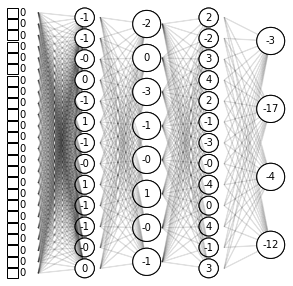

In [83]:
show_network(walker, [0]*24)

So our NeuralNet class can learn to walk, as well as play Pong!

The only changes we need to make are to handle the different input and output sizes:

  - Pong observations were 5 values, and we had 3 actions
  - Walker observations are 24 values (positions of the joints, their rotation, distances to the grown, shown by the red beams) and we have 4 actions

Lets try to train our own walker:
We need to update out evaluation function to handle a single player - this should be even simpler than before!

In [84]:
def evaluate_walker(walker, max_steps=5000):  
    # Setup the game
    # We are going to use an environemnt from OpenAI
    # This is a single agent environment, so instead of observations, actions and rewards for each side, we only have one.
    # This is the only difference!

    env = gym.make('BipedalWalker-v3')
    observation = env.reset()

    # We record the score, or 'reward' for the walker
    totalReward = 0
    # The game is run in steps, where each player gets to pick their action
    for step in range(max_steps):
        # In the walker environment, the AI picks an action every step
        # The walker decides its action based on their senses 'observing' the world
        action = walker.getOutput(observation)

        # We progress the game one step based on the selected action of the walker.
        # The game sends back the next observation
        observation, reward, done, info = env.step(action)
        totalReward += reward
        if done:
            break
    return totalReward

In [85]:
def evaluate_walker_population(pop, n_tests=5):

  # We will be playing a few games with each member, so lets create a record of the rewards they earn
  reward_record = {}

  # Initialize records for each member
  for pop_i, nn in list(enumerate(pop.population)):
    reward_record[pop_i] = []

  # We are going to test each AI n_tests times
  for i in range(n_tests):
    print(f"Test {i}")
    # Loop testing each member of the population
    for pop_i, nn in list(enumerate(pop.population)):

      # lets get the record for games this AI has already played
      member_record = reward_record[pop_i]

      reward = evaluate_walker(nn)
      member_record.append(reward)

  
  min_pop_fitness = 100000
  max_pop_fitness = -100000
  avg_pop_fitness = 0
  best_player = None
  # Now lets set the fitness of each AI to be its average score
  for pop_i, nn in enumerate(pop.population):
        rewards = reward_record[pop_i]
        avg_reward = np.mean(rewards)
        nn.fitness = avg_reward

        # And track min, max and avg of the population
        min_pop_fitness = min(min_pop_fitness, nn.fitness)
        avg_pop_fitness += nn.fitness
        if nn.fitness > max_pop_fitness :
            max_pop_fitness = nn.fitness
            best_player = nn
  avg_pop_fitness /= len(pop.population)
  return min_pop_fitness, avg_pop_fitness, max_pop_fitness, best_player

Now lets train a walker!

In [86]:
MAX_STEPS = 2500

# Increase this to evolve for more generations!
# Will give better results
MAX_GENERATIONS = 5
POPULATION_COUNT = 50
MUTATION_RATE = 0.02
COMPARISON_TESTS = 1

input_dimensions = 24
output_dimensions = 4

# We first create a population of neural networks.
# For each generation, the neural networks play eachother, recording their performance into reward_map
# Once we have the fitness scores for all NNs, we evolve a new generation. We randomly select some NNs to pass into
# the next generation, with better performing NNs being more likely.
# We then fill the rest of the generation with children, which inherit from randomly selected parents.
pop = Population(POPULATION_COUNT, MUTATION_RATE, [input_dimensions, 13, 8, 13, output_dimensions])

for gen in range(MAX_GENERATIONS):
    min_pop_fitness, avg_pop_fitness, max_pop_fitness, best_player = evaluate_walker_population(pop, n_tests=COMPARISON_TESTS)
    print(f"Generation: {gen} | Min: {min_pop_fitness} | Max: {max_pop_fitness} | Avg: {avg_pop_fitness}")

    # Create New Generation!
    pop.createNewGeneration()

Test 0
Generation: 0 | Min: -186.89183417377524 | Max: -102.14680181896681 | Avg: -131.92258980598442
Test 0
Generation: 1 | Min: -185.36183440117065 | Max: -100.75355168744066 | Avg: -119.99480884921174
Test 0
Generation: 2 | Min: -181.4721694218317 | Max: -92.71751788269086 | Avg: -122.00395406441419
Test 0
Generation: 3 | Min: -181.13194955346282 | Max: -90.6790683143284 | Avg: -115.15323786228723
Test 0
Generation: 4 | Min: -187.3024738584633 | Max: -90.66668542293124 | Avg: -115.76669529139204


In [89]:
recordWalker(best_player)


 Recording Walker
---------------------
Game Finished! The walker got a score of -91.33962418418842


In [88]:
show_video()

# Fin

So in summary:

  - We looked at how a human brain would play a gain, and simplified it down into receiving inputs, processing inputs, and producing output
  - We realized we could simulate this process, using layers of artificial neurons
  - In order for our AI brains to work well, we need to find the right parameters, ones which turn valid inputs into correct outputs
  - We used Genetic Evolution to find AI brains which correctly solve a task
  - We used this idea to train pong players,
  - And walkers!

Now its your turn! How can you take this idea further? Can you make your AI play a game only using screen input? What other methods of finding a good brain are there? 